## Function definitions and Prompt templates

In [4]:
import re
import os
import random
import time
from datetime import date
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pyathena import connect
import boto3
from botocore.exceptions import ClientError
import openai
from openai import OpenAI
import json
import math
import pyarrow.parquet as pq
import tiktoken
import faiss
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings

%matplotlib inline
sns.set_theme()

In [5]:
class SecretManager:
    def __init__(self, secret_name, region_name="us-east-1"):
        self.secret_name = secret_name
        self.region_name = region_name
        self.client = boto3.session.Session().client(
            service_name='secretsmanager', 
            region_name=region_name
        )
        
    def get_secret(self, api_key_name):
        try:
            get_secret_value_response = self.client.get_secret_value(
                SecretId=self.secret_name
            )
        except ClientError as e:
            # For a list of exceptions thrown, see
            # https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
            raise e

        secret = get_secret_value_response['SecretString']

        return json.loads(secret)[api_key_name]

In [6]:
class S3ParquetLoader:
    def __init__(self, bucket_name, prefix, file_identifier="s3://"):
        self.bucket_name = bucket_name
        self.prefix = prefix
        self.file_identifier = file_identifier
        
    def load_s3_parquet(self, file):
        s3_path = self.file_identifier + self.bucket_name + self.prefix + file
        return pq.read_table(s3_path).to_pandas()

In [7]:
class OpenAIClient:
    def __init__(self, model='gpt-4o-mini', seed=12345, temperature=0, tools=None):
        self.model = model
        self.seed = seed
        self.temperature = temperature
        self.tools = tools
        self.client = OpenAI()
    
    def get_completion(self, message):
        response = self.client.chat.completions.create(
            model=self.model,
            response_format={ "type": "json_object" },
            messages=[
                {
                    "role": "system",
                    "content": "You are a helpful assistant designed to output JSON.",
                },
                {"role": "user", "content": message},
            ],
            temperature=self.temperature,
            # max_tokens=max_tokens,
            seed=self.seed,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0 # seed=1001
    )
    
        return response # response_format={ "type": "json_object"}, designed to output JSON

In [8]:
class TpwireDataLoader:
    def __init__(self, bucket_name, prefix, file_identifier="s3://"):
        self.s3_loader = S3ParquetLoader(bucket_name, prefix, file_identifier)
        
    def process_data(self, file_name):
        data = self.s3_loader.load_s3_parquet(file_name)
        # final_df = data[['summaryplaintext', 'publishdate', 'multi_story_flag', 'table_flag']]
        final_df = data
        final_df = final_df[(final_df['multi_story_flag'] == False) & (final_df['table_flag'] == False)]
        
        # tpwire_df = final_df[['summaryplaintext', 'publishdate']]
        tpwire_df = final_df.drop(['multi_story_flag', 'table_flag'], axis=1)
        tpwire_df = tpwire_df.sort_values(by='publishdate').reset_index(drop=True)
        tpwire_df['publishdate'] = tpwire_df['publishdate'].apply(lambda x: np.datetime64(x).astype(datetime).date()) # change to standard date format
        
        return tpwire_df

In [9]:
class tpwireRAG:
    def __init__(self, embed):
        self.embed = embed
        self.index_tb = None
        self.vec_db = None
        self.prompt_template = '''
        Use the following pieces of context to help you answer the question at the end. 

        If you don't know the answer, just output: "Answer": <I don't know the answer>. Don't try to make up an answer. 

        Keep the answer as concise as possible.

        Context: {context}
        Question: {search_text}
        
        "Answer": <answer> 
        ''' # Always say "thanks for asking!" at the end of the answer. 
        
    def index_document(self, df):
        # for idx in range(len(df)):
        chunks = df['summaryplaintext'].tolist()
        
        self.index_tb = pd.DataFrame({
        'Content': chunks,
        'Vectors': embed.embed_documents(chunks), # 'original_index': range(len(chunks)),
        })

        self.index_tb.reset_index(drop=True, inplace=True)

        return self.index_tb
    
    def build_vec_db(self, index_tb):
        if not self.index_tb:
            self.index_tb = index_tb
        
        vectors = np.array(self.index_tb['Vectors'].tolist(), dtype='float32')
        vec_dim = vectors.shape[1]
        self.vec_db = faiss.IndexFlatL2(vec_dim)
        faiss.normalize_L2(vectors)
        self.vec_db.add(vectors)

        # return self.vec_db
        
        
    def retrieve_from_vec_db(self, search_text, K):
        search_vectors = self.embed.embed_documents([search_text])
        faiss.normalize_L2(np.array(search_vectors, dtype='float32'))

        distances, ann = self.vec_db.search(np.array(search_vectors, dtype='float32'), k=K)

        results = pd.DataFrame({'distances': distances[0], 'ann': ann[0]})

        merge = pd.merge(results, self.index_tb, left_on='ann', right_index=True)

        # # If you need data from the original dataframe:
        # merge = pd.merge(merge, original_df, left_on='original_index', right_index=True)

        return merge
    
    @staticmethod
    def combine_context(relevant_contents): # Helper function for generating context
        context = relevant_contents.Content
        context = '\n'.join(context)

        return context
    
    def generate_context_prompt(self, search_text, K):
        relevant_contents = self.retrieve_from_vec_db(search_text=search_text, K=K)
        context = self.combine_context(relevant_contents=relevant_contents)
        prompt = self.prompt_template.format(context=context, search_text=search_text)
        return relevant_contents, prompt 

In [10]:
# prompt_template = '''
# Use the following pieces of context to help you answer the question at the end. 

# If you don't know the answer, just say that you don't know, don't try to make up an answer. 

# Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 

# Context: {context}
# Question: {search_text}
# Helpful Answer: 
# '''

## Initialize env and class

### Setting env variables

In [11]:
# API key setting
SECRET_NAME= "AmazonSageMaker-sagemarker_yuwen"
secret_manager = SecretManager(secret_name=SECRET_NAME)
os.environ['OPENAI_API_KEY'] = secret_manager.get_secret('OPENAI_API_KEY')

### Set constant variable

In [12]:
BUCKET_NAME, PREFIX = "trepp-developmentservices-datascience/", "llm-exploration/treppwire_rag/"

MODEL = 'gpt-3.5-turbo-0125'
EMBED_MODEL_NAME = 'text-embedding-ada-002'
embed = OpenAIEmbeddings(model=EMBED_MODEL_NAME) # Create embeddings for indexing documents
K = 5 # Number of relevant chunks

### Class initialization

In [13]:
openai_client = OpenAIClient(model=MODEL)

# S3 parquet loader
s3_parquet_loader = S3ParquetLoader(bucket_name=BUCKET_NAME, prefix=PREFIX)

# Import TreppWire data
tpwire_loader = TpwireDataLoader(bucket_name=BUCKET_NAME, prefix=PREFIX)

# Initialize treppwire RAG
tpwire_RAG = tpwireRAG(embed=embed)

## Import data

In [14]:
tpwire_df = tpwire_loader.process_data("tpwire_flags.parquet")
tpwire_df

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,...,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
0,3eed7ccc305ff0e7d259fecacaa0c241fd48015d8ef413...,50998,mclancy@trepp.com,Manus Clancy,TreppWire,post,[DBJPM 2016-C3],<h4><strong>Purchase of Seattle-Area Office Fi...,Purchase of Seattle-Area Office FinalizedThe R...,[390132],...,[Medical Office],[Office],[OF],[CA],[Alameda],[Oakland],"[San Francisco-Oakland-Hayward, CA]",[1 Kaiser Plaza],[Pacific],2019-01-02
1,c187de254e73aff2b22b7f25efc7945dc8ce89bcba7f7f...,50998,mclancy@trepp.com,Manus Clancy,TreppWire,post,[DBJPM 2016-C3],<h4><strong>San Francisco Office Behind 2017 L...,San Francisco Office Behind 2017 Loan Acquired...,[390132],...,[Medical Office],[Office],[OF],[CA],[Alameda],[Oakland],"[San Francisco-Oakland-Hayward, CA]",[1 Kaiser Plaza],[Pacific],2019-01-02
2,aa0de93c31614f2533617779d6343a6f6c708ba9017046...,51027,mclancy@trepp.com,Manus Clancy,TreppWire,post,[GSMS 2013-GC14],<ul>\n<li>The overall US CMBS delinquency rate...,The overall US CMBS delinquency rate decrease...,[329689],...,[Community Shopping Center],[Retail],[RT],[IL],[Peoria],[Peoria],"[Peoria, IL]",[Willow Knolls Court],[East North Central],2019-01-03
3,e235e5b2038f2617902d3ca0b75d19ce84f927bffba8a2...,51027,mclancy@trepp.com,Manus Clancy,TreppWire,post,[GSMS 2013-GC14],<h4><strong>Retail Property Behind CMBX 7 Loan...,Retail Property Behind CMBX 7 Loan to Lose Top...,[329689],...,[Community Shopping Center],[Retail],[RT],[IL],[Peoria],[Peoria],"[Peoria, IL]",[Willow Knolls Court],[East North Central],2019-01-03
4,0f5e20e57aafb684eb5a2051f816f114154ae9a75a7849...,51027,mclancy@trepp.com,Manus Clancy,TreppWire,post,[GSMS 2013-GC14],<ul>\n<li>The CMBS 1.0 delinquency rate decrea...,The CMBS 1.0 delinquency rate decreased 47 ba...,[329689],...,[Community Shopping Center],[Retail],[RT],[IL],[Peoria],[Peoria],"[Peoria, IL]",[Willow Knolls Court],[East North Central],2019-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3613,f2d51a2006a5e8e7b09b94d11a9af692135b26682f8d7f...,57207,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],"<table cellpadding=""0"" cellspacing=""0"" role=""p...",⇨ Orange County Mall Loan Now in the Han...,[],...,[],[],[],[],[],[],[],[],[],2024-03-26
3614,0c5f0453b3cae3512de98a3119ed3ddfbd576ec6102011...,57211,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],"<table cellpadding=""0"" cellspacing=""0"" role=""p...",⇨ Cupertino Hilton Hotel Loan Transferre...,[],...,[],[],[],[],[],[],[],[],[],2024-03-27
3615,1412c58f039f440abb93bbab6eeef528dcf91a2959f889...,57211,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],"<table cellpadding=""0"" cellspacing=""0"" role=""p...",⇨ San Francisco Office Loan Taken to Spe...,[],...,[],[],[],[],[],[],[],[],[],2024-03-27
3616,57bab2bd3ab498abe44a50d3e0c9069f46f39074e8e6a7...,57214,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],"<table cellpadding=""0"" cellspacing=""0"" role=""p...",⇨ Bankruptcy Filed for Washington D.C. O...,[],...,[],[],[],[],[],[],[],[],[],2024-03-28


In [15]:
# index_tb = index_document(tpwire_df, embed)
# index_tb = tpwire_RAG.index_document(tpwire_df)
# index_tb.Content[2]

In [16]:
# index_tb.to_parquet('treppwire_index_tb.parquet')

In [17]:
# index_tb = pd.read_parquet('treppwire_index_tb.parquet')
index_tb = s3_parquet_loader.load_s3_parquet('treppwire_index_tb.parquet')

In [18]:
index_tb

,Content,Vectors
0,Purchase of Seattle-Area Office FinalizedThe R...,"[0.013301508501172066, -0.009327195584774017, ..."
1,San Francisco Office Behind 2017 Loan Acquired...,"[0.0029433900490403175, -0.01179976761341095, ..."
2,The overall US CMBS delinquency rate decrease...,"[-0.034419845789670944, 0.001670714351348579, ..."
3,Retail Property Behind CMBX 7 Loan to Lose Top...,"[-0.01970122568309307, -0.014349104836583138, ..."
4,The CMBS 1.0 delinquency rate decreased 47 ba...,"[-0.016646970063447952, -0.0006964138592593372..."
...,...,...
3613,⇨ Orange County Mall Loan Now in the Han...,"[-0.004349840339273214, -0.016529392451047897,..."
3614,⇨ Cupertino Hilton Hotel Loan Transferre...,"[-0.003111459081992507, -0.01287689059972763, ..."
3615,⇨ San Francisco Office Loan Taken to Spe...,"[-0.0039004357531666756, -0.019137587398290634..."
3616,⇨ Bankruptcy Filed for Washington D.C. O...,"[-0.02221551537513733, -0.005892913788557053, ..."


In [19]:
tpwire_RAG.build_vec_db(index_tb=index_tb)

## Retrieve most K=5 relevant chunks from vector database

In [17]:
# search_text = 'What percentage of space does the Kroger grocery store occupy in the Northern Lights Shopping Center loan that will end in 2019?'
# search_text = 'What top tenants vacates in the Northern Lights Shopping Center Loan?'
# search_text = 'Could you tell me what happened with CMBS Loans in October 2023 in a concise manner? Thanks.'
# search_text = 'What was DSCR for Mall at Tuttle Crossing loan in 2022?'
# search_text = 'Could you give me information about Solano Mall loan?'
# search_text = 'Could you give me information about the property backed behind Solano Mall loan?'
# search_text = 'What do you think about the future of commercial real estate loans in USA?'
# search_text = 'How was loan default situation for New York comparing with California?'
# search_text = 'What commerical real estate loans we have to pay attention to this year 2024?'
# search_text = 'Is there anything about the NYC Worldwide Plaza?'
# search_text = 'What is the current status of Ohio Mall in the latest credit story?'
# search_text = 'Can you provide an overview of the financial details for Ohio Mall Loan recorded this month?'
# search_text = 'How has the occupancy rate for Ohio Mall changed in the recent report?'
# search_text= 'What is the most recent status of Big Philly Office Loan?'
# search_text = 'What are the key updates about the sale of Dulaney Center?'
# search_text = 'Can you provide an overview about National Business Park loan?'
# search_text = 'How was the occupancy rate for Doner Company in the recent report?'
# search_text = 'Could you summarize the recent financial performance of Chicago Hotel?'
# search_text = 'What significant events have occurred for Chicago Hotel?'
# search_text = 'How has the value of Waterfront at Port Chester evolved according to the latest credit report?'
# search_text = 'What are the main points of concern for IDS Center loan mentioned this month?'
# search_text = 'Could you detail the transactions involving One Concords Center?'
# search_text = 'What are the highlights of the latest credit story for WeWork?'
# search_text = 'How was the delinquency status of Aviation Mall been addressed in the latest update?'
# search_text = 'What new information is available about the refinancing of [New York Hospitality Portfolio loan]?'
# search_text = 'Could you provide a brief on the recent sales details of Courtyard Louisville Airport?'
# search_text = 'What changes in valuation have been recorded for North Riverside Park Mall this month?'
# search_text = 'How does the latest credit story describe the financial health of SASB Office Loan?'
# search_text = 'Could you summarize the deal that Hughes Center Las Vegas belongs to?'
# search_text = 'Could you summarize the main details of sales of Ozarks Hotel?'
# search_text = 'Could you summarize the loan details of Ozarks Hotel?'
# search_text= 'What are the highlights of the special servicing history for Cupertino Hilton Hotel Loan?'
# search_text = 'Could you summarize the valuation changes for Cranberry Woods Office Park over the years?'

In [18]:
search_text = 'What is the recent price of Flagler Corporate Center loan?'
# search_text = 'How many square feet does the Bridgewater Commons mall in New Jersey contain?'
# search_text = 'What is the loan amount for the IDS Center property in Minneapolis?'
# search_text = 'What year was the Colman Building originated, has it undergone any renovations?'
# search_text = 'What is the occupancy rate of The Commons at Sawmill near Northern Arizona University?'
# search_text = 'How does the recent sale price of NMS Northridge and NMS Superior properties compare to their previous valuation?'
# search_text = 'Could you provide information on the location and size of the West Ridge Mall & Plaza?'
# search_text = 'What is the DSCR (NCF) for the 184-unit community in San Bernardino in the most recent quarter?'
# search_text = 'Who was the buyer in the recent transaction of Osprey Pointe Apartments in St. Petersburg?'
# search_text = 'Could you provide original loan amount and current status about the Fifth Avenue loan?'
# search_text = 'What percentage of the Starwood Mall Portfolio loan does the MacArthur Center Mall represent?'
# search_text = 'What type of property is the 644 Broadway loan, and what are its primary uses?'
# search_text = 'What recent updates have there been regarding the changes of properties associated with CMBX 6 deal?'
# search_text = 'How has the valuation of the Cincinnati Hotel changed since 2019?'
# search_text = 'Has the Enclave West student housing loan in Edwardsville been sent to special servicing? If so, when?'
# search_text = 'What recent changes have occurred with the Greentree Plaza retail center in Everett?'
# search_text = 'How does the current occupancy rate of Atlanta hotel compare to previous year?'
# search_text = 'Which CMBX series does the deal involving the San Isidro Plaza I & II loan belong to?'
# search_text = 'What is the current delinquency status of the loan backed by the US Bank Tower in Downtown Denver?'
# search_text = 'What is the maturity date of the loan backing the Alexander Place Apartments property in Charlotte?'

In [19]:
# search_text = 'What are the top 5 largest transactions by dollar amount in Manhattan this quarter this month?'
# search_text = 'Can you list all office properties in Houston, TX with a loan amount above $50 million?'
# search_text = 'How many office buildings were sold in West Palm Beach and Irmo during the first half of 2021?'
# search_text = 'What is the current occupancy rate for the Jacksonville retail property in Florida based on the latest available data?'
# search_text = 'Show me all properties built before 2010 that were sold in the last quarter.'
# search_text = 'Which property in Elizabeth, NJ had the highest price per square foot this year?'
# search_text = 'What are the 3 most recent transactions for properties larger than 200,000 square feet in Texas?'
# search_text = 'Which properties in Akron, Ohio have experienced a significant decrease in occupancy due to tenant turnover in the past year?'
# search_text = "What's the total value of all retail properties in Lakeland, FL that have undergone appraisal reductions in the past quarter?"
# search_text = 'What is the total transaction volume for the Huntsville, AL Apartments property in 2021?'
# search_text = 'How many properties in East Lansing, MI have a DSCR below 1.0?'
# search_text = "What's the average construction year of retail properties sold behind CMBX 12 loans?"
# search_text = 'List all properties where the largest tenant represents over 80% of underwritten base rent'
# search_text = 'How many properties in New York City are currently facing foreclosure?'
# search_text = 'What is the total square footage of all properties involved in the recent credit stories?'
# search_text = 'Can you show me all transactions in Tampa, FL where the occupancy rate decreased by at least 20% post-sale?'
# search_text = 'List the 5 largest loans (by dollar amount) that were sent to special servicing in Region S this quarter.'
# search_text = "What's the average lease renewal duration for retail properties in Chicago in the last 12 months?"
# search_text = 'What properties in Pennsylvania sold for more than $5 million and less than $15 million recently?'
# search_text = 'Can you rank the top 3 buyers by total square footage acquired in Manhattan for office properties this quarter?'
# search_text = 'Could you provide information on any credit stories related to loan modifications or paydowns for properties in the last quarter?'
# search_text = 'What are the recent credit stories involving properties with appraisal reductions?'
# search_text = 'Could you provide information on loans that are currently in special servicing?'
# search_text = 'Are there any credit stories from this month regarding properties undergoing refinancing or loan modifications?'
# search_text = 'Can you provide credit stories where there have been significant changes in occupancy rates and DSCR for loans or properties?'

### Hallucination (data point retrieval)

In [20]:
# search_text = 'How many multifamily communities were sold in Las Vegas in 2018?'
# search_text = 'Show me all properties built before 1975 that were sold in the last quarter.'
# search_text = 'What was the recent sale price of Property X?'
# search_text = 'When was Avalon Riverview, Long island city constructed, and has it undergone any renovations?'
# search_text = 'What are the primary uses of Macy"s?'
# search_text = 'What''s the average age of office buildings sold this quarter?'
# search_text = 'What is the CMBX series that the Dartmouth Mall loan is part of?'
# search_text = 'What is the current occupancy rate of the Empire State Building in New York, NY?'
# search_text = 'Has there been any recent news or updates regarding the sale of the 55 Green Street property?'
# search_text = 'Has the loan behind the North Carolina medical office building been refinanced recently?'
# search_text = 'What is the current vacancy rate of the Blackwell Plaza property?'
# search_text = 'What is the recent DSCR of the $108.8 million Embassy Suites loan backing the JPMCC 2019-EMBS deal in Manhattan?'
# search_text = 'What caused the significant drop in occupancy rate at Jackson Park in Long Island City from 96% in 2019 to 59% in September 2018?'
# search_text = 'What''s the LTV of Gotham Point property in Queens?'
# search_text = 'Who was the buyer in the recent transaction of Rockefellar Center?'
# search_text = 'What is the current outstanding balance of the 55 Broadway loan?'
# search_text = 'What was the DSCR (NCF) for Crossgates Mall in 2021?'
# search_text = 'What is the likelihood of Schwab subletting the space at 211 Main Street in San Francisco?'
# search_text = 'How has the valuation of Property X changed over the past few years?'
# search_text = 'What"s the location and size of property X?'
# search_text = 'How many square feet does 55 Broadway loan have?

### Hallucination (general summary)

In [21]:
# search_text = 'List the 3 most recent transactions for properties larger than X square feet in State G.'
# search_text = 'Could you provide an overview of for Rockefeller Center loan?'
# search_text = 'What significant events have occurred for Chicago Hotel in 2024?' 
# search_text = 'What are the key updates about the sale of Rockefeller Center in 2024?'
# search_text = 'What are the highlights of credit story for North Carolina medical office building in 2018?'
# search_text = 'Could you summarize the deal that property X belongs to?'
# search_text = 'What changes in valuation have been recorded for Hmart Mall?'
# search_text = 'Could you summarize the main details of transactions of New York Central Park?'
# search_text = 'How was the delinquency status of Empire State Building been addressed in the latest update?'
# search_text = 'Could you provide the details about world trade center sent to special servicing?'
# search_text = 'What was the loss severity percentage for the Jacksonville retail property loan resolution this month?'
# search_text = 'What impact does the transition of property to the lender have on the financial health of Virginia Mall Loan?'
# search_text = 'What modifications were made to the loan for 11 West 42nd Street property in June 2018?'
# search_text = 'What are the main factors contributing to the imminent default of the Fifth Avenue loan in Washington, DC?'
# searc_text = 'What was the outcome of the bankruptcy auction for the Lower Manhattan mixed-use property at 78 Bowery Street?'
# search_text = 'What was the resolution outcome for the Rockefeller Center loan in New York, NY?'
# search_text = 'What impact did the departure of Clock Tower Village have on the Fox River Mall loan?'
# search_text = 'What are the implications of the recent tenant changes at One Newark Center for the Cupertino Hilton Hotel Loan?'
# search_text = 'How has the value of Crossgates Mall loan evolved this year?'
# search_text = 'What was the final outstanding balance loss percentage for the Ozarks Hotel property asset resolution?'

### Hallucination (Metadata filtering)

In [22]:
# search_text = 'What are the 5 transactions in New York in Dec, 2023?'
# search_text = 'What"s the average time on market for Property Type Multifamily sold in New York in the last 6 months?'
# search_text = 'What was the occupancy rate of The Clusters apartment community at 4416 Northcrest Drive in Midland, TX in 2019?'
# search_text = 'What properties in State NY sold for more than $10 million and less than $100 million this year?'
# search_text = 'What was the Bank of America Plaza Loan DSCR in 2022?'
# search_text = 'What is the total Loan Per Square Foot (LPSF) for Bank of America Plaza in St. Louis?'
# search_text = "What's the total Jamaica Center Cinema lease length?"
# search_text = 'Has the East Village Multifamily Portfolio Pool 2 loan LTV increased since securitized? If so, how much of the increase.'

In [23]:
relevant_contents, prompt = tpwire_RAG.generate_context_prompt(search_text=search_text, K=K)

In [24]:
relevant_contents

,distances,ann,Content,Vectors
0,0.247765,3469,Big Change Coming for Big Miami Office Loan?Mo...,"[-0.0012216087197884917, -0.009146752767264843..."
1,0.247765,3472,Big Change Coming for Big Miami Office Loan?Mo...,"[-0.0012216087197884917, -0.009146752767264843..."
2,0.306649,1061,Value of FL Office Behind Big Legacy Loan Redu...,"[-0.0019075110321864486, 0.0032472286839038134..."
3,0.307488,1515,New Jersey Office Loan ExtendedThe $24.4 milli...,"[-0.024548841640353203, -0.021423442289233208,..."
4,0.310713,2161,Value of Florida Mall Loan Lowered AgainJune s...,"[-0.03102140873670578, -0.008310261182487011, ..."


## Combine context AND output answer

In [25]:
response = openai_client.get_completion(message=prompt)

In [26]:
json.loads(response.choices[0].message.content)['Answer']

'$205 million'

In [394]:
# tpwire_df.head(20)

# Execution

In [7]:
import os, json
from langchain_openai import OpenAIEmbeddings
from utils_rag import SecretManager, OpenAIClient, S3ParquetLoader, TpwireDataLoader, tpwireRAG
from config import SECRET_NAME, BUCKET_NAME, PREFIX, MODEL, EMBED_MODEL_NAME, K

In [8]:
if __name__ == "__main__":
    secret_manager = SecretManager(secret_name=SECRET_NAME)
    os.environ['OPENAI_API_KEY'] = secret_manager.get_secret('OPENAI_API_KEY')
    
    embed = OpenAIEmbeddings(model=EMBED_MODEL_NAME) # Create embeddings for indexing documents
    
    openai_client = OpenAIClient(model=MODEL)

    # S3 parquet loader
    s3_parquet_loader = S3ParquetLoader(bucket_name=BUCKET_NAME, prefix=PREFIX)

    # Import TreppWire data
    tpwire_loader = TpwireDataLoader(bucket_name=BUCKET_NAME, prefix=PREFIX)

    # Initialize treppwire RAG
    tpwire_RAG = tpwireRAG(embed=embed)
    
    
    tpwire_df = tpwire_loader.process_data("tpwire_flags.parquet")
    # index_tb = index_document(tpwire_df, embed)
    # index_tb = tpwire_RAG.index_document(tpwire_df)
    # index_tb.to_parquet('treppwire_index_tb.parquet')
    # index_tb = pd.read_parquet('treppwire_index_tb.parquet')
    index_tb = s3_parquet_loader.load_s3_parquet('treppwire_index_tb.parquet')
    
    tpwire_RAG.build_vec_db(index_tb=index_tb)
    
    search_text = 'What is the recent price of Flagler Corporate Center loan?'
    relevant_contents, prompt = tpwire_RAG.generate_context_prompt(search_text=search_text, K=K)
    response = openai_client.get_completion(message=prompt)
    print(f"The answer is: {json.loads(response.choices[0].message.content)['Answer']}")

The answer is: The recent price of the Flagler Corporate Center loan is $205 million, as Miami-Dade County could acquire the property for that amount.


## * Try to find questions

In [20]:
# prompt1 = """
#     I give you a template general data point retrieval question and a context about credit stories of different properties. 
#     I want you to come up with a general data point retrieval question (not a template) by understanding the context I gave. 
#     (only fill in property/loan/deal into template questions, don't change other things. Questions shouldn't be very 
#     specific or accurate because you should simulate the real person''s asking)
    
#     Template question: {question}
#     context: {context}
    
#     Output the answer in this format:
#     {{
#         "Specific_question": "<Question>"
#     }}
    
#     Do not include any other text or information besides the specified JSON output.
# """

prompt1 = """
    I give you a template general summary question and a context about credit stories of different properties. 
    I want you to come up with a general data point retrieval hallucination question that GPT cannot answer (not a template) by understanding the context I gave. 
    (only fill in property/loan/deal into template questions, don't change other things.)
    
    Template question: {question}
    context: {context}
    
    Output the answer in this format:
    {{
        "Specific_question": "<Question>"
    }}
    
    Do not include any other text or information besides the specified JSON output.
"""

#### Template questions (General summary)

In [18]:
template_question = [
    'What is the most recent status of Big Philly Office Loan?',
    'What are the key updates about the sale of Dulaney Center?',
    'Can you provide an overview of for National Business Park loan?',
    'How was the occupancy rate for Doner Company in the recent report?',
    'Can you summarize the recent financial performance of Chicago Hotel?',
    'What significant events have occurred for Chicago Hotel (after 2022)?',
    'How has the value of Waterfront at Port Chester loanevolved according to the latest credit report?',
    'What are the main points of concern for IDS Center loan mentioned (this month)?',
    'Can you detail the (recent) transactions involving One Concords Center?',
    'What are the highlights of the latest credit story for WeWork?',
    'How was the delinquency status of Aviation Mall been addressed in the latest update?',
    'What new information is available about the refinancing of New York Hospitality Portfolio loan?',
    'Could you provide a brief on the recent sales details of Courtyard Louisville Airport?',
    'What changes in valuation have been recorded for North Riverside Park Mall (this month)?',
    'How does the latest credit story describe the financial health of SASB Office Loan?',
    'Could you summarize the deal that Hughes Center Las Vegas belongs to?',
    'Could you summarize the main details of sales of Ozarks Hotel?',
    'Could you summarize the loan details of Ozarks Hotel?',
    'What are the highlights of the special servicing history for Cupertino Hilton Hotel Loan?',
    'Could you summarize the valuation changes for Cranberry Woods Office Park (over the years)?',
]

In [35]:
# template_question = [
#     'What was the recent sale price of Property X?',
#     'How many square feet does Building A have?',
#     'How much is the loan amount for Mall A?',
#     'When was Building A originally constructed, and has it undergone any renovations?',
#     'What''s the current occupancy/vacancy rate of Property X?',
#     'How does the sale price of Property X compare to its previous valuation?',
#     'Could you provide details on the location and size of Shopping Center X?',
#     'What''s the DSCR (NCF) for Mall X in the most recent quarter?',
#     'Who was the buyer in the recent transaction of Property X?',
#     'Can you give me information about the loan associated with Property X, including its original amount and current status?',
#     'What percentage of deal L does the loan for mall M represent?',
#     'What type of property is Building X, and what are its primary uses?',
#     'Has there been any recent news or updates regarding the sale of Mall X?',
#     'How has the valuation of Property X changed over the past few years?',
#     'Has Loan R been in special servicing? If so, when?',
#     'Are there any notable features or recent improvements to Office Building X?',
#     'How does the current occupancy rate of Property X compare to its rate from the previous year?',
#     'Can you provide the CMBX series that the deal L is part of?',
#     'What is delinquency status of loan O?',
#     'What is maturity date of Loan X?',
# ]

#### Template questions (Metadata filtering)

In [36]:
# template_question = [
#     'What are the top 5 largest transactions by dollar amount in City X this month?',
#     'Can you list all office properties sold in State X with a price per square foot above $Y?',
#     'How many mixed-use properties were sold in Region X during Month Y, Year Z?',
#     "What's the average occupancy rate for shopping malls in Metropolitan Area X based on recent transactions?",
#     'Show me all properties built before Year Y that were sold in the last quarter.',
#     'Which Property Type X had the highest price per square foot in City F this year?',
#     'List the 3 most recent transactions for properties larger than X square feet in State G.',
#     'What properties in City H have undergone renovations in the last 5 years and were sold this month?',
#     "What's the total value of all Property Type X transactions in Region J for this quarter?",
#     'Can you rank the top 5 MSAs by total transaction volume for Property Type K this year?',
#     'How many properties with a DSCR below 1.0 were sold in State L in the past 6 months?',
#     "What's the average age of office buildings sold in City M this quarter?",
#     'List all transactions in Region N where the sale price was at least 20% below the previous valuation.',
#     'How many properties in State O changed hands for the second time in 3 years?',
#     "What's the total square footage of all Property Type P sold in City Q this month?",
#     'Can you show me all transactions in MSA R where the occupancy rate increased by at least 10% post-sale?',
#     'List the 5 largest loans (by dollar amount) that were sent to special servicing in Region S this quarter.',
#     "What's the average time on market for Property Type T sold in City U in the last 6 months?",
#     'What properties in State V sold for more than $X million and less than $Y million this year?',
#     'Can you rank the top 3 buyers by total square footage acquired in Region W for Property Type Z this quarter?',
#     'Can you show me all credit stories related to loan modifications or paydowns in the last quarter?',
#     'What are the recent credit stories involving properties with appraisal reductions?',
#     'Could you filter the credit stories to show only those about loans in special servicing?',
#     'Are there any credit stories from this month regarding properties undergoing foreclosure?',
#     'Can you list the credit stories that involve significant status changes for loans or properties?'
# ]

In [143]:
res = []
for q in template_question:
    idxs = random.sample(list(range(len(tpwire_df))), 3)
    context = '\n'.join(tpwire_df.loc[idxs, 'summaryplaintext'].values)
    prompt2 = prompt1.format(question=q, context=context)
    response = openai_client.get_completion(message=prompt2)
    res.append(json.loads(response.choices[0].message.content)['Specific_question'])
    
res

['What was the occupancy rate of the Square 95 retail property in Woodbridge, VA when the new tenant took possession of the vacant space in August 2022?',
 'What was the occupancy rate of The Arbors Apartments at the time of sale?',
 'What is the current occupancy rate of the Gallery at Harborplace property in Baltimore?',
 'What was the DSCR (NCF) for the 660 Madison Avenue Retail loan in 2021?',
 'What is the current occupancy rate of the San Francisco T-Mobile store at 1 Stockton Street?',
 'What was the resolution outcome for the Riverview Center loan in Menands, NY?',
 'How has the value of Crossgates Mall loan evolved according to the latest credit report?',
 'What impact did the departure of Younkers and Sears have on the Fox River Mall loan?',
 'What are the recent developments regarding the $7 million Towers of Coral Springs loan behind GSMS 2012-GC6?',
 'What impact does the closure of the Petco location at Madonna Plaza in San Luis Obispo have on the $33.8 million Madonna Pl

In [39]:
res = [json.loads(i) for i in res]

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
res

In [ ]:
template_question[11]

In [129]:
idxs = random.sample(list(range(len(tpwire_df))), 3)
context = '\n'.join(tpwire_df.loc[idxs, 'summaryplaintext'].values)
prompt2 = prompt1.format(question=template_question[11], context=context)
response = openai_client.get_completion(message=prompt2)
json.loads(response.choices[0].message.content)

{'Specific_question': "What's the average construction year of retail properties sold behind CMBX 12 loans?"}

### Metadata Filtering Questions

In [13]:
tpwire_df.head()

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,...,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
0,3eed7ccc305ff0e7d259fecacaa0c241fd48015d8ef413...,50998,mclancy@trepp.com,Manus Clancy,TreppWire,post,[DBJPM 2016-C3],<h4><strong>Purchase of Seattle-Area Office Fi...,Purchase of Seattle-Area Office FinalizedThe R...,[390132],...,[Medical Office],[Office],[OF],[CA],[Alameda],[Oakland],"[San Francisco-Oakland-Hayward, CA]",[1 Kaiser Plaza],[Pacific],2019-01-02
1,c187de254e73aff2b22b7f25efc7945dc8ce89bcba7f7f...,50998,mclancy@trepp.com,Manus Clancy,TreppWire,post,[DBJPM 2016-C3],<h4><strong>San Francisco Office Behind 2017 L...,San Francisco Office Behind 2017 Loan Acquired...,[390132],...,[Medical Office],[Office],[OF],[CA],[Alameda],[Oakland],"[San Francisco-Oakland-Hayward, CA]",[1 Kaiser Plaza],[Pacific],2019-01-02
2,aa0de93c31614f2533617779d6343a6f6c708ba9017046...,51027,mclancy@trepp.com,Manus Clancy,TreppWire,post,[GSMS 2013-GC14],<ul>\n<li>The overall US CMBS delinquency rate...,The overall US CMBS delinquency rate decrease...,[329689],...,[Community Shopping Center],[Retail],[RT],[IL],[Peoria],[Peoria],"[Peoria, IL]",[Willow Knolls Court],[East North Central],2019-01-03
3,e235e5b2038f2617902d3ca0b75d19ce84f927bffba8a2...,51027,mclancy@trepp.com,Manus Clancy,TreppWire,post,[GSMS 2013-GC14],<h4><strong>Retail Property Behind CMBX 7 Loan...,Retail Property Behind CMBX 7 Loan to Lose Top...,[329689],...,[Community Shopping Center],[Retail],[RT],[IL],[Peoria],[Peoria],"[Peoria, IL]",[Willow Knolls Court],[East North Central],2019-01-03
4,0f5e20e57aafb684eb5a2051f816f114154ae9a75a7849...,51027,mclancy@trepp.com,Manus Clancy,TreppWire,post,[GSMS 2013-GC14],<ul>\n<li>The CMBS 1.0 delinquency rate decrea...,The CMBS 1.0 delinquency rate decreased 47 ba...,[329689],...,[Community Shopping Center],[Retail],[RT],[IL],[Peoria],[Peoria],"[Peoria, IL]",[Willow Knolls Court],[East North Central],2019-01-03


#### What are the 5 transactions in New York in Dec, 2023?

In [14]:
def within_quarter(date1, date2=date.today()):
    '''
    params:
    - date1: the date to compare with date1
    - date2: center

    output:
    - Boolean value
    '''
    return (date1.month//4+1 == date2.month//4+1) & (date1.year == date2.year)


def within_month(date1, date2=date.today()):
    '''
    params:
    - date1: the date to compare with date1
    - date2: center

    output:
    - Boolean value
    '''
    
    return (date1.year == date2.year) & (date1.month == date1.month)

In [95]:
df = tpwire_df[(tpwire_df['city'] == '[New York]') & (tpwire_df['publishdate'] >= date(2023, 12, 1)) & (tpwire_df['publishdate'] <= date(2023, 12, 31))]
df

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,...,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
3484,f6930974582e1561d7d080ade2952e0b5a080b04bcaf41...,56854,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[COMM 2014-CR15],"<h4 style=""font-size: 16px; line-height: 175%;...",Not So Fast: 625 Madison Avenue Ground Lease L...,[337812],...,[Urban Office],[Office],[OF],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[25 West 45th Street],[Middle Atlantic],2023-12-14
3486,b4d5bc1e9530889f6c4ad8a9c822e9e41997da34c7d1c8...,56854,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[COMM 2014-CR15],"<h4 style=""font-size: 16px; line-height: 156%;...",Big NYC Office Loan Expected to Miss Maturity ...,[337812],...,[Urban Office],[Office],[OF],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[25 West 45th Street],[Middle Atlantic],2023-12-14
3487,fd94eea1c0c38d28f0cb50d3b9be17091e32de5d60eff8...,56860,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[JPMCC 2021-1440],"<h4 style=""font-size: 16px; line-height: 175%;...","Retail Complex in La Quinta Sold, Loan Defease...",[487406],...,[Mixed Use],[Office/Retail],[OF],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[1440 Broadway],[Middle Atlantic],2023-12-15
3488,54f05bf18adef0f4c75ee4ab6074f47fd2d37cec4acfe7...,56860,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[JPMCC 2021-1440],"<h4 style=""font-size: 16px; line-height: 175%;...",CMBX 8 Office Loan Goes 30 Days DelinquentA fe...,[487406],...,[Mixed Use],[Office/Retail],[OF],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[1440 Broadway],[Middle Atlantic],2023-12-15
3489,34d382c456961ffa18d8cf21f99675a257472df5d4701b...,56860,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[JPMCC 2021-1440],"<h4 style=""font-size: 16px; line-height: 156%;...",Trepp Flash: WeWork Renegotiates Lease for Big...,[487406],...,[Mixed Use],[Office/Retail],[OF],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[1440 Broadway],[Middle Atlantic],2023-12-15
3490,11abcc4b1ef43edfdf8b7dea95ddc35c80a603f2b04eb4...,56860,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[JPMCC 2021-1440],"<h4 style=""font-size: 16px; line-height: 175%;...",Trading Alert: Extension for One South Wacker ...,[487406],...,[Mixed Use],[Office/Retail],[OF],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[1440 Broadway],[Middle Atlantic],2023-12-15
3491,ac3ba5b5035c595266fb1a83361ffa91a011944ed656a2...,56866,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[BFLD 2020-EYP],<h4><strong>Big West Side Manhattan Mixed Use ...,Big West Side Manhattan Mixed Use Loan Sent to...,[349634],...,[Mixed Use],[Mixed Use],[MU],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[Columbus Square Portfolio],[Middle Atlantic],2023-12-18
3499,517dff565e6367ee35743242f498fa338146ed3deaab2c...,56875,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[COMM 2013-CR8],<h4><strong>Trading Alert: NYC’s Seagram Build...,Trading Alert: NYC’s Seagram Building Refinanc...,[316089],...,[Mixed Use],[Mixed Use],[MU],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[The Prince Building],[Middle Atlantic],2023-12-20
3509,9a553eccb0889413f38911442ed9ef3dc0f9573a2fae41...,56896,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[UBSBB 2013-C5],"<h4 style=""font-size: 16px; line-height: 175%;...",Good Holiday Cheer for Distressed PA Office Lo...,[360652],...,[Urban Office],[Office],[OF],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[200 Park Avenue],[Middle Atlantic],2023-12-26
3510,3302fc597d53f3252ca50c56af3404d53e0e2d26525e3a...,56896,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[UBSBB 2013-C5],"<h4 style=""font-size: 16px; line-height: 175%;...",132K-SF Office Property in Canton SoldHuntingt...,[360652],...,[Urban Office],[Of

In [110]:
print('\n\n'.join(df.summaryplaintext.tolist()))

Not So Fast: 625 Madison Avenue Ground Lease Loan Not RetiredEarlier this month we noted that SL Green was selling 625 Madison Avenue in Manhattan for $633 million.We won’t go through all the details again, but the short story was this: SL Green owned the office at that address; the office was subject to a ground lease owned by Ashkenazy Acquisition Corp. which securitized that revenue with a CMBS loan. SL Green bought the debt on the ground lease and turned the tables on Ashkenazy which had been trying to take ownership of the office. Got that? If not, The Real Deal did a nice job explaining the issue in a June article.In our prior reporting, we assumed the sale would result in the payoff of the $193.9 million ground lease loan on 625 Madison Avenue which can be freely paid off at any time. However, the loan was not paid off, this month. In fact, the special servicer comments this month indicated that the borrower requested a loan modification, and a modification agreement was execute

In [69]:
prompt_1 = """
    Given the context, help me extract the state the story is talking about:
    
    context: {context}
    
    Output:
    "State": <>
    
    """

In [86]:
for i in range(len(df)):
    prompt_2 = prompt_1.format(context=df.summaryplaintext.iloc[i])
    response = openai_client.get_completion(message=prompt_2)
    print(json.loads(response.choices[0].message.content))

{'State': 'New York'}
{'State': 'New York'}
{'State': 'CA'}
{'State': 'MI'}
{'State': 'New York'}
{'State': 'Illinois'}
{'State': 'New York'}
{'State': 'New York'}
{'State': 'PA'}
{'State': 'Ohio'}
{'State': 'Connecticut'}


In [94]:
print('\n\n'.join(df.summaryplaintext.iloc[[0, 1, 4, 6, 7]].tolist()))

Not So Fast: 625 Madison Avenue Ground Lease Loan Not RetiredEarlier this month we noted that SL Green was selling 625 Madison Avenue in Manhattan for $633 million.We won’t go through all the details again, but the short story was this: SL Green owned the office at that address; the office was subject to a ground lease owned by Ashkenazy Acquisition Corp. which securitized that revenue with a CMBS loan. SL Green bought the debt on the ground lease and turned the tables on Ashkenazy which had been trying to take ownership of the office. Got that? If not, The Real Deal did a nice job explaining the issue in a June article.In our prior reporting, we assumed the sale would result in the payoff of the $193.9 million ground lease loan on 625 Madison Avenue which can be freely paid off at any time. However, the loan was not paid off, this month. In fact, the special servicer comments this month indicated that the borrower requested a loan modification, and a modification agreement was execute

#### Can you list properties involved in deal FREMF 2019-K92?

In [106]:
df_2 = tpwire_df[tpwire_df['dealname'] == '[FREMF 2019-K92]']
df_2

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,...,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
3525,da04e247c5dfbc93817ed19944a3ae37c2d27021fb6a5b...,56963,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[FREMF 2019-K92],"<h4 style=""font-size: 16px; line-height: 175%;...",⇨ Durham Apartments Sell for Big Price501 Esta...,[527195],...,[Garden / Low-Rise],[Multifamily],[MF],[NC],[Durham],[Durham],"[Durham-Chapel Hill, NC]",[501 Estates (f/k/a Century Trinity Estates)],[South Atlantic],2024-01-05


In [105]:
print('\n\n'.join(df_2.summaryplaintext.tolist()))

⇨ Durham Apartments Sell for Big Price501 Estates – also known as Century Trinity Estates Apartments – has been sold for $73 million, according to the Triangle Business Journal. Price represents a nearly 50% increase from 2019 when the property sold for $49 million. The property also sold in 2013 for $38.6 million.The property is a 270-unit complex at 240 Ivy Meadow Lane. The more recent sale represents more than $270,000 per unit.The property backs two FHLMC loans. The $33.5 million Century Trinity Estates loan makes up 2.31% of FREMF 2019-K92. The loan matures in 2029 and is locked out until early that year.In addition, the $5.4 million 501 Estates (f/k/a Century Trinity Estates) loan which makes up 2.22% of FREMF 2022-KJ43FX. The loan matures in 2029 and can be prepaid with yield maintenance.Jefferson Apartment Group purchased the property from Spyglass Capital Partners LLC. 


In [107]:
prompt_2 = """
    Given the context, give me the property involved in the context:
    
    context: {context}
    
    Output:
    "State": <>
    
    """

In [108]:
prompt_3 = prompt_2.format(context=df_2.summaryplaintext.iloc[0])
response = openai_client.get_completion(message=prompt_3)
print(json.loads(response.choices[0].message.content))

{'Property': 'Durham Apartments'}


#### Could you list all stories about office properties in Houston, TX after 2020?

In [134]:
pd.set_option('display.max_columns', 50)

tpwire_df.iloc[-120:-100]

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,loadtype,postcategory,postcategoryname,dealid,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
3498,782e2cb908b68c51b5a9021d522de863b0d360263d2c83...,56870,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[GSMS 2014-GC26],<h4><strong>Another Concern for NYC Mixed-Use ...,Another Concern for NYC Mixed-Use Property?A f...,[348916],full_load,477,Daily Commentary,[3082],[Urban Office],[Office],[OF],[CA],[Los Angeles],[Los Angeles],"[Los Angeles-Long Beach-Anaheim, CA]",[Bank of America Plaza],[Pacific],2023-12-19
3499,517dff565e6367ee35743242f498fa338146ed3deaab2c...,56875,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[COMM 2013-CR8],<h4><strong>Trading Alert: NYC’s Seagram Build...,Trading Alert: NYC’s Seagram Building Refinanc...,[316089],full_load,477,Daily Commentary,[2624],[Mixed Use],[Mixed Use],[MU],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[The Prince Building],[Middle Atlantic],2023-12-20
3500,6002083c0024c0888356d6de698212da6f50cab085d4ef...,56875,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[COMM 2013-CR6],<h4><strong>Trading Alert: FEMA to Move From D...,Trading Alert: FEMA to Move From DC Office Beh...,[316099],full_load,477,Daily Commentary,[2544],[Regional Mall],[Retail],[RT],[CA],[Solano],[Fairfield],"[Vallejo-Fairfield, CA]",[Solano Mall],[Pacific],2023-12-20
3501,be7e738c2096c2140c59962c535758f3b6ed976494bec7...,56884,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[COMM 2018-HCLV],<h4><strong>Office Property in Austin Sold</st...,"Office Property in Austin SoldA 250,000-square...",[429060],full_load,477,Daily Commentary,[4504],"[Convenience Center, Unclassified, Single Tena...","[Retail, Office]","[RT, OF]",[NV],[Clark],[Las Vegas],"[Las Vegas-Henderson-Paradise, NV]","[Del Friscos, 3930 Howard Hughes Parkway, 3800...",[Mountain],2023-12-21
3502,1352061d8115fbb4be41d337f362764e680d7f14ef38be...,56884,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[COMM 2018-HCLV],<p><strong>Hughes Center Las Vegas Occupancy D...,Hughes Center Las Vegas Occupancy Drops Furthe...,[429060],full_load,477,Daily Commentary,[4504],"[Convenience Center, Unclassified, Single Tena...","[Retail, Office]","[RT, OF]",[NV],[Clark],[Las Vegas],"[Las Vegas-Henderson-Paradise, NV]","[Del Friscos, 3930 Howard Hughes Parkway, 3800...",[Mountain],2023-12-21
3503,ec829c78789cd97b09d1e216752ac5cb3cd81fff817f27...,56884,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[COMM 2018-HCLV],<h4><strong>Borrower Behind Troy Office Inflat...,Borrower Behind Troy Office Inflated Property ...,[429060],full_load,477,Daily Commentary,[4504],"[Convenience Center, Unclassified, Single Tena...","[Retail, Office]","[RT, OF]",[NV],[Clark],[Las Vegas],"[Las Vegas-Henderson-Paradise, NV]","[Del Friscos, 3930 Howard Hughes Parkway, 3800...",[Mountain],2023-12-21
3504,7531e704499c7a3c68ad6d7f4926d07344b2fbff6a5aa0...,56884,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[COMM 2018-HCLV],<h4><strong>Follow Up: 2018 Loan Industrial Lo...,Follow Up: 2018 Loan Industrial Loan Goes 30 D...,[429060],full_load,477,Daily Commentary,[4504],"[Convenience Center, Unclassified, Single Tena...","[Retail, Office]","[RT, OF]",[NV],[Clark],[Las Vegas],"[Las Vegas-Henderson-Paradise, NV]","[Del Friscos, 3930 Howard Hughes Parkway, 3800...",[Mountain],2023-12-21
3505,1cdbbffa568daff613a031f18acded3d7b0f2fe75971bd...,56890,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[WFRBS 2013-C18],<h4><strong>San Francisco Retail Loan Goes 30 ...,San Francisco Retail Loan Goes 30 Days Delinqu...,[480804],full_load,477,Daily Commentary,[2782],[Urban / Street Retail],[Retail],[RT],[CA],[San Francisco],[San Francisco],"[San Francisco-Oakland-Hayward, CA]",[One Stockton],[Pacific],2023-12-22
3506,c306d1f63eca424b8b103ad84c59b6e83f6f90890b0436...,56890,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[W

In [116]:
df_3 = tpwire_df[(tpwire_df['proptypecode'] == '[MF]') & (tpwire_df['city'] == '[Houston]')]
df_3

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,loadtype,postcategory,postcategoryname,dealid,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
11,e0588e3e923131e0dc1f1d48ff06dcbaac71934cf397c3...,51135,mclancy@trepp.com,Manus Clancy,TreppWire,post,[BBCMS 2013-TYSN],<h4><strong>Houston Apartments Behind 2015 Dea...,Houston Apartments Behind 2015 Deals SoldAccor...,[359166],full_load,477,Daily Commentary,[2678],[Garden / Low-Rise],[Multifamily],[MF],[TX],[Harris],[Houston],"[Houston-Baytown-Sugar Land, TX, Houston-The W...","[Cranbrook Multifamily Portfolio, Monticello o...",[West South Central],2019-01-11
12,36f0711928dc0c9be55ced123afd92d7084e218f469eeb...,51135,mclancy@trepp.com,Manus Clancy,TreppWire,post,[BBCMS 2013-TYSN],<h4><strong>Quick Hit: Value Behind Georgia St...,Quick Hit: Value Behind Georgia Student Housin...,[359166],full_load,477,Daily Commentary,[2678],[Garden / Low-Rise],[Multifamily],[MF],[TX],[Harris],[Houston],"[Houston-Baytown-Sugar Land, TX, Houston-The W...","[Cranbrook Multifamily Portfolio, Monticello o...",[West South Central],2019-01-11
804,f47d531fef381b6c06fd549d4098eb3a64819a36cac1d7...,54127,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[FREMF 2017-KJ13],<h4><strong>Houston Apartment Behind Two Agenc...,Houston Apartment Behind Two Agency Loans Sold...,[306521],full_load,477,Daily Commentary,[3892],[Mid / High-Rise],[Multifamily],[MF],[TX],[Harris],[Houston],"[Houston-The Woodlands-Sugar Land, TX]",[Lofts At The Ballpark],[West South Central],2020-06-22
875,2372890f3ef60fc739b9dfb4b58c28ba893c1aeb9cfa58...,54207,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[UBSCM 2017-C3],<h4><strong>Houston Apartment Complex Sold for...,Houston Apartment Complex Sold for $51 Million...,[411239],full_load,477,Daily Commentary,[4040],[Garden / Low-Rise],[Multifamily],[MF],[TX],[Harris],[Houston],"[Houston-The Woodlands-Sugar Land, TX]",[Broadstone Park West],[West South Central],2020-08-05
1188,34d210835be4e0995ed5e9050c9b22b56fa5f7db952ee3...,54592,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[JPMBB 2015-C29],<h4><strong>Houston Apartment Loan Becomes 30 ...,Houston Apartment Loan Becomes 30 Days Delinqu...,[363785],full_load,477,Daily Commentary,[3256],[Garden / Low-Rise],[Multifamily],[MF],[TX],[Harris],[Houston],"[Houston-The Woodlands-Sugar Land, TX]",[Alta Woodlake Square],[West South Central],2021-02-22
2215,022f377710552cb5288ed5eaf09226d34e16d44d12ff82...,55556,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[JPMBB 2014-C21],<h4><strong>Apartment Community Behind 2021 Pr...,Apartment Community Behind 2021 Private-Label ...,[502015],full_load,477,Daily Commentary,[2939],[Mid / High-Rise],[Multifamily],[MF],[TX],[Harris],[Houston],"[Houston-The Woodlands-Sugar Land, TX]",[City Lake Apartments],[West South Central],2022-07-12


In [137]:
prompt_3 = """
    Given the context, give me the property involved in the context:
    
    context: {context}
    
    Output:
    "Property": <>
    
    """

In [115]:
for i in range(len(df_3)):
    prompt_31 = prompt_3.format(context=df_3.summaryplaintext.iloc[0])
    response = openai_client.get_completion(message=prompt_31)
    print(json.loads(response.choices[0].message.content))

{'Property': 'Houston Apartments'}
{'Property': 'Houston Apartments'}
{'Property': 'Timbers of Cranbrook, Monticello on Cranbrook, Pecan Square Village (formerly known as Polo Club on Cranbrook)'}
{'Property': 'Houston Apartments'}
{'Property': 'Timbers of Cranbrook, Monticello on Cranbrook, Pecan Square Village (formerly known as Polo Club on Cranbrook)'}
{'Property': 'Houston Apartments'}


In [120]:
print('\n\n'.join(df_3.iloc[-2:].summaryplaintext.tolist()))

Houston Apartment Loan Becomes 30 Days DelinquentAccording to February remittance data for the $30.7 million Alta Woodlake Square loan, the note became 30 days delinquent this month.The collateral is a 256-unit multifamily complex in Houston, TX. The property was built in 2013.For 2019, the loan posted a DSCR (NCF) of 1.19x when occupancy was 93%. Those numbers dipped to 0.91x and 90% for the first nine months of 2020.The collateral was valued at $40.3 million in 2015.The loan makes up 4.39% of the collateral behind JPMBB 2015-C29. The note was sent to special servicing in December due to payment default under the mezzanine loan. The mezzanine lender is pursuing an equity enforcement action and is requesting a modification to the senior loan in conjunction with the equity enforcement action. Stay tuned. 

Apartment Community Behind 2021 Private-Label Deal SellsThe Regard at Medical Center, a 319-unit apartment community at 8877 Lakes at 610 Drive in Houston, TX has been acquired by The

#### What Convenience Center properties are in the Los Angeles-Long Beach-Anaheim, CA msa area?

In [136]:
df_4 = tpwire_df[(tpwire_df['msaname'] == '[Los Angeles-Long Beach-Anaheim, CA]') & (tpwire_df['propertysubtype'] == '[Convenience Center]')]
df_4

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,loadtype,postcategory,postcategoryname,dealid,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
39,7a77cb6498ec0d6d5ceb353ae51d7e64d8393d0b1f875f...,51359,mclancy@trepp.com,Manus Clancy,TreppWire,post,[COMM 2013-CR8],<h4><strong>Main Tenant Behind 2011 Loan Renew...,Main Tenant Behind 2011 Loan RenewsAccording t...,[281063],full_load,477,Daily Commentary,[2624],[Convenience Center],[Retail],[RT],[CA],[Los Angeles],[Santa Monica],"[Los Angeles-Long Beach-Anaheim, CA]",[1452 Third Street Promenade],[Pacific],2019-01-25
194,6d14cb88bb1e1327196eca6e216d49919de7fcfdb68d54...,52377,mclancy@trepp.com,Manus Clancy,TreppWire,post,[CD 2017-CD5],<h4><strong>Top Tenant Behind 2017 California ...,Top Tenant Behind 2017 California Retail Loan ...,[405566],full_load,477,Daily Commentary,[3997],[Convenience Center],[Retail],[RT],[CA],[Los Angeles],[Santa Monica],"[Los Angeles-Long Beach-Anaheim, CA]",[1322 3rd Street Promenade],[Pacific],2019-04-04
195,9b007431a2b0da5319ef3fd2a207ba748259e85c6b6611...,52377,mclancy@trepp.com,Manus Clancy,TreppWire,post,[BSCMS 2006-PW11],<h4><strong>Long Saga of Former AT&amp;T Illin...,Long Saga of Former AT&amp;T Illinois Office N...,[405566],full_load,477,Daily Commentary,[1442],[Convenience Center],[Retail],[RT],[CA],[Los Angeles],[Santa Monica],"[Los Angeles-Long Beach-Anaheim, CA]",[1322 3rd Street Promenade],[Pacific],2019-04-04
2015,f05c1282efd6342b1db1453118f7c4a61b9aea3960cf23...,55431,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[COMM 2014-CR20],<h4><strong>Retail Center Behind CMBX 8 Loan S...,Retail Center Behind CMBX 8 Loan SoldPacific P...,[352771],full_load,477,Daily Commentary,[3044],[Convenience Center],[Retail],[RT],[CA],[Los Angeles],[Torrance],"[Los Angeles-Long Beach-Anaheim, CA]",[Pacific Plaza],[Pacific],2022-04-22


In [140]:
for i in range(len(df_4)):
    prompt_31 = prompt_3.format(context=df_4.summaryplaintext.iloc[i])
    response = openai_client.get_completion(message=prompt_31)
    print(json.loads(response.choices[0].message.content))

{'Property': '1452 Third Street Promenade'}
{'Property': '1322 3rd Street Promenade'}
{'Property': 'Former AT&T office in Hoffman Estates, Illinois'}
{'Property': 'Pacific Plaza'}


In [142]:
print('\n\n'.join(df_4.summaryplaintext.tolist()))

Main Tenant Behind 2011 Loan RenewsAccording to January watchlist notes for the $16.3 million 1452 Third Street Promenade loan, the dominant tenant at the collateral has renewed for three years. The loan makes up 1.82% of DBUBS 2011-LC1A and matures in November 2020.The collateral is a 17,789 square-foot retail parcel in Santa Monica, California that was built back when William McKinley was President in 1898. It was renovated in 2008. Top tenant H&amp;M occupies 93.3% of the space under a current lease that expires in July 2019. New servicer comments reveal that H&amp;M has renewed for three years, which extends the retailer’s lease to July 2022.The loan had been cash trapped since H&amp;M had just executed the lease renewal. Servicer commentary from November indicated that H&amp;M’s plans were “unclear” as of late 2018.For the 12 months ending in September 2018, the loan posted a DSCR (NCF) of 1.62x. The loan was underwritten with an LTV of 67% and is marked as current.

Top Tenant Be

#### Which loans in the MAD 2019-650M deal are associated with properties located in New York?

In [148]:
df_5 = tpwire_df[(tpwire_df['dealname'] == '[GSMS 2014-GC26]') & (tpwire_df['city'] == '[New York]')]
df_5

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,loadtype,postcategory,postcategoryname,dealid,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
958,8a734865aef8aedf0482ab9cd20ad652c03780ee7c889a...,54274,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[GSMS 2014-GC26],<h4><strong>Follow-up: Value of California Ret...,Follow-up: Value of California Retail Center R...,[354979],full_load,477,Daily Commentary,[3082],[Urban / Street Retail],[Retail],[RT],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[IGT Retail Condominium],[Middle Atlantic],2020-09-15
959,6e289ff7b24f843f1683144ea3c7ed8cf131c0480f9bcc...,54274,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[GSMS 2014-GC26],<h4><strong>Diamonds Are Forever – How About N...,Diamonds Are Forever – How About NYC Diamond S...,[354979],full_load,477,Daily Commentary,[3082],[Urban / Street Retail],[Retail],[RT],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[IGT Retail Condominium],[Middle Atlantic],2020-09-15
960,cd9421f9b594611f1e61480a3656cafba69e6fdfeb0197...,54274,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[GSMS 2014-GC26],<h4><strong>New Law Firm Lease For Office Back...,New Law Firm Lease For Office Backing 2018 Loa...,[354979],full_load,477,Daily Commentary,[3082],[Urban / Street Retail],[Retail],[RT],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[IGT Retail Condominium],[Middle Atlantic],2020-09-15
2354,179767a56b8cd8fd706386c06acf48319ab2e56cc6110a...,55732,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[GSMS 2014-GC26],<h4><strong>Trading Alert: Previously Modified...,Trading Alert: Previously Modified New Jersey ...,[348349],full_load,477,Daily Commentary,[3082],[Mixed Use],[Mixed Use],[MU],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]","[Cipriani Wall Street, Cipriani 42nd Street]",[Middle Atlantic],2022-09-14
2358,38f617c63497d8b16928f0a30ef48212fb08f11a8aa2c0...,55732,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[GSMS 2014-GC26],<h4><strong>Value of REO Hawaii Mall Reduced S...,Value of REO Hawaii Mall Reduced SlightlyServi...,[348349],full_load,477,Daily Commentary,[3082],[Mixed Use],[Mixed Use],[MU],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]","[Cipriani Wall Street, Cipriani 42nd Street]",[Middle Atlantic],2022-09-14


In [159]:
prompt_4 = """
    Given the context, Could you give me loan name and the reason if it has properties in New York. If not, just tell me "I don' know about such loan".
    You should think step by step.
    
    context: {context}
    
    Output:
    "loan_name": <>
    "reason": <>
    
    """

In [160]:
for i in range(len(df_5)):
    prompt_41 = prompt_4.format(context=df_5.summaryplaintext.iloc[i])
    response = openai_client.get_completion(message=prompt_41)
    print(json.loads(response.choices[0].message.content))

{'loan_name': 'CGCMT 2007-C6', 'reason': "I don't know about such loan"}
{'loan_name': 'IGT Retail Condominium loan', 'reason': "The collateral is located in New York City's diamond district on 47th Street, occupied by small diamond sellers."}
{'loan_name': 'Miamisburg Office Portfolio loan', 'reason': 'The loan is backed by properties in Miami Township, OH, not New York.'}
{'loan_name': 'Newport Centre loan', 'reason': "The property is located in Jersey City, New Jersey, not New York. Therefore, I don't know about such loan."}
{'loan_name': "I don't know about such loan", 'reason': ''}


In [161]:
print('\n\n'.join(df_5.summaryplaintext.tolist()))

Follow-up: Value of California Retail Center ReducedAccording to September servicer data, the value of the REO Crossroads Marketplace asset has been reduced. The asset has an outstanding balance of $62 million which represents 46.4% of the remaining collateral behind CGCMT 2007-C6.The subject property is a 263,757-square-foot shopping center in Chino Hills, CA. The property was built in 2000 and is primarily occupied by Bed Bath &amp; Beyond, PetSmart, and CVS.At securitization, the property was valued at $79 million. Prior to the release of September data, the collateral was valued at $55.6 million. This month, the appraised valued was lowered to $44 million while the appraisal reduction amount (ARA) was upped from $24.7 million to $33.6 million.The asset has been in special servicing since late 2016.In 2016, we noted that the retail center’s largest tenant was Sport Chalet, which occupied 42,000 square feet (16% NRA). The sporting goods chain filed for Chapter 11 that year and liquid

#### What was the Bank of America Plaza Loan DSCR in 2022?

In [248]:
pd.set_option('display.max_columns', 50)

tpwire_df.iloc[-120:-100]

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,loadtype,postcategory,postcategoryname,dealid,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
3498,782e2cb908b68c51b5a9021d522de863b0d360263d2c83...,56870,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[GSMS 2014-GC26],<h4><strong>Another Concern for NYC Mixed-Use ...,Another Concern for NYC Mixed-Use Property?A f...,[348916],full_load,477,Daily Commentary,[3082],[Urban Office],[Office],[OF],[CA],[Los Angeles],[Los Angeles],"[Los Angeles-Long Beach-Anaheim, CA]",[Bank of America Plaza],[Pacific],2023-12-19
3499,517dff565e6367ee35743242f498fa338146ed3deaab2c...,56875,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[COMM 2013-CR8],<h4><strong>Trading Alert: NYC’s Seagram Build...,Trading Alert: NYC’s Seagram Building Refinanc...,[316089],full_load,477,Daily Commentary,[2624],[Mixed Use],[Mixed Use],[MU],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[The Prince Building],[Middle Atlantic],2023-12-20
3500,6002083c0024c0888356d6de698212da6f50cab085d4ef...,56875,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[COMM 2013-CR6],<h4><strong>Trading Alert: FEMA to Move From D...,Trading Alert: FEMA to Move From DC Office Beh...,[316099],full_load,477,Daily Commentary,[2544],[Regional Mall],[Retail],[RT],[CA],[Solano],[Fairfield],"[Vallejo-Fairfield, CA]",[Solano Mall],[Pacific],2023-12-20
3501,be7e738c2096c2140c59962c535758f3b6ed976494bec7...,56884,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[COMM 2018-HCLV],<h4><strong>Office Property in Austin Sold</st...,"Office Property in Austin SoldA 250,000-square...",[429060],full_load,477,Daily Commentary,[4504],"[Convenience Center, Unclassified, Single Tena...","[Retail, Office]","[RT, OF]",[NV],[Clark],[Las Vegas],"[Las Vegas-Henderson-Paradise, NV]","[Del Friscos, 3930 Howard Hughes Parkway, 3800...",[Mountain],2023-12-21
3502,1352061d8115fbb4be41d337f362764e680d7f14ef38be...,56884,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[COMM 2018-HCLV],<p><strong>Hughes Center Las Vegas Occupancy D...,Hughes Center Las Vegas Occupancy Drops Furthe...,[429060],full_load,477,Daily Commentary,[4504],"[Convenience Center, Unclassified, Single Tena...","[Retail, Office]","[RT, OF]",[NV],[Clark],[Las Vegas],"[Las Vegas-Henderson-Paradise, NV]","[Del Friscos, 3930 Howard Hughes Parkway, 3800...",[Mountain],2023-12-21
3503,ec829c78789cd97b09d1e216752ac5cb3cd81fff817f27...,56884,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[COMM 2018-HCLV],<h4><strong>Borrower Behind Troy Office Inflat...,Borrower Behind Troy Office Inflated Property ...,[429060],full_load,477,Daily Commentary,[4504],"[Convenience Center, Unclassified, Single Tena...","[Retail, Office]","[RT, OF]",[NV],[Clark],[Las Vegas],"[Las Vegas-Henderson-Paradise, NV]","[Del Friscos, 3930 Howard Hughes Parkway, 3800...",[Mountain],2023-12-21
3504,7531e704499c7a3c68ad6d7f4926d07344b2fbff6a5aa0...,56884,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[COMM 2018-HCLV],<h4><strong>Follow Up: 2018 Loan Industrial Lo...,Follow Up: 2018 Loan Industrial Loan Goes 30 D...,[429060],full_load,477,Daily Commentary,[4504],"[Convenience Center, Unclassified, Single Tena...","[Retail, Office]","[RT, OF]",[NV],[Clark],[Las Vegas],"[Las Vegas-Henderson-Paradise, NV]","[Del Friscos, 3930 Howard Hughes Parkway, 3800...",[Mountain],2023-12-21
3505,1cdbbffa568daff613a031f18acded3d7b0f2fe75971bd...,56890,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[WFRBS 2013-C18],<h4><strong>San Francisco Retail Loan Goes 30 ...,San Francisco Retail Loan Goes 30 Days Delinqu...,[480804],full_load,477,Daily Commentary,[2782],[Urban / Street Retail],[Retail],[RT],[CA],[San Francisco],[San Francisco],"[San Francisco-Oakland-Hayward, CA]",[One Stockton],[Pacific],2023-12-22
3506,c306d1f63eca424b8b103ad84c59b6e83f6f90890b0436...,56890,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[W

In [275]:
df_6 = tpwire_df[(tpwire_df['loanname'] == '[Bank of America Plaza]')] # & (tpwire_df['publishdate'].apply(lambda x: x.year==2023))
df_6

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,loadtype,postcategory,postcategoryname,dealid,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
55,122fc8d46b6c937ef99ead0ba5571356d39661deff09cf...,51478,mclancy@trepp.com,Manus Clancy,TreppWire,post,[GSMS 2015-GC30],<h4><strong>St. Louis Office Tower to Lose Sec...,St. Louis Office Tower to Lose Second-Largest ...,[362636],full_load,477,Daily Commentary,[3240],[Urban Office],[Office],[OF],[MO],[Saint Louis City],[St. Louis],"[St. Louis, MO-IL]",[Bank of America Plaza],[West North Central],2019-02-01
1037,71537ea937e1ba5c16d74df6d44473c06eb35f9434cd42...,54370,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[BXMT 2020-FL2],<ul>\n<li>The CMBS 2.0+ delinquency rate fell ...,The CMBS 2.0+ delinquency rate fell 65 basis ...,[459532],full_load,477,Daily Commentary,[5155],[Urban Office],[Office],[OF],[GA],[Fulton],[Atlanta],"[Atlanta-Sandy Springs-Roswell, GA]",[Bank of America Plaza],[South Atlantic],2020-11-02
1038,b385f549aa9deaddc6f6604d85281ac91575d72c2c3c4f...,54370,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[BXMT 2020-FL2],<h4><strong>Quick Hit: Lease Renewal for Calif...,Quick Hit: Lease Renewal for California Office...,[459532],full_load,477,Daily Commentary,[5155],[Urban Office],[Office],[OF],[GA],[Fulton],[Atlanta],"[Atlanta-Sandy Springs-Roswell, GA]",[Bank of America Plaza],[South Atlantic],2020-11-02
1039,d48a1c99f0ca384408d3ca021bfbc975710a39ab54d98e...,54370,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[BXMT 2020-FL2],<ul>\n<li>The overall US CMBS delinquency rate...,The overall US CMBS delinquency rate dropped ...,[459532],full_load,477,Daily Commentary,[5155],[Urban Office],[Office],[OF],[GA],[Fulton],[Atlanta],"[Atlanta-Sandy Springs-Roswell, GA]",[Bank of America Plaza],[South Atlantic],2020-11-02
1040,9ed0e2636ffc0cfb7888ea26aa8be20f342158e0ffe1c7...,54370,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[BXMT 2020-FL2],<h4><strong>CMBS Delinquency Rate Continues Re...,CMBS Delinquency Rate Continues Retreat in Oct...,[459532],full_load,477,Daily Commentary,[5155],[Urban Office],[Office],[OF],[GA],[Fulton],[Atlanta],"[Atlanta-Sandy Springs-Roswell, GA]",[Bank of America Plaza],[South Atlantic],2020-11-02
1041,65cfe8ff414b97a50cccdb8088e6984fda85182fa0668f...,54370,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[BXMT 2020-FL2],<h4><strong>New Address for Atlanta Law Firm B...,New Address for Atlanta Law Firm Behind 2020 L...,[459532],full_load,477,Daily Commentary,[5155],[Urban Office],[Office],[OF],[GA],[Fulton],[Atlanta],"[Atlanta-Sandy Springs-Roswell, GA]",[Bank of America Plaza],[South Atlantic],2020-11-02
1920,b6c7b9459903146543f2c6651344eccb5b96cd879565ac...,55348,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[BXMT 2020-FL2],<h4><strong>Bank of America Plaza in Atlanta A...,Bank of America Plaza in Atlanta Acquired By C...,[459532],full_load,477,Daily Commentary,[5155],[Urban Office],[Office],[OF],[GA],[Fulton],[Atlanta],"[Atlanta-Sandy Springs-Roswell, GA]",[Bank of America Plaza],[South Atlantic],2022-03-04
1921,c052a6b9cfb05ced26bec9f6b9656180e8869eb4ce77f2...,55348,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[GSMS 2015-GC30],<h4><strong>Bank of America Looking to Subleas...,Bank of America Looking to Sublease St. Louis ...,[362636],full_load,477,Daily Commentary,[3240],[Urban Office],[Office],[OF],[MO],[Saint Louis City],[St. Louis],"[St. Louis, MO-IL]",[Bank of America Plaza],[West North Central],2022-03-04
2570,9cf3aed9d2444bb60aece2aa2cb988ecd00ea34c5813d4...,55992,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[CGCMT 2017-P8],<h4><strong>Trading Alert: Top Tenant Behind M...,Trading Alert: Top Tenant Behind Michigan Offi...,[408520],full_load,477,Daily Commentary,[4067],[Suburban Office],[Office],[OF],[MI],[Oakland],[Troy],"[Detroit-Warren-Dearborn, MI]",[Bank of America Plaza],[East North Central],2022-12-22
2

In [270]:
print('\n\n'.join(df_6.summaryplaintext.tolist()))

St. Louis Bank of America Plaza Loan Goes to Special ServicingAccording to June remittance data, the $45 million Bank of America Plaza loan has been sent to special servicing.The collateral is a 733,669-square-foot office at 800 Market Street in St. Louis. Bank of America is the top tenant with 29.4% of the space on a lease that ends this month. TreppWire readers might recall that about 15 months ago, we noted that BOA was looking to sublease about two-thirds of the space in that St. Louis office. Later, the bank moved about 110 workers in the firm’s wealth management arm out of the property. The property also has several other major leases ending between H2 2023 and 2025. The loan posted a DSCR (NCF) of 1.48x in 2022 when occupancy was 83%.The loan makes up 4.61% of the remaining collateral behind GSMS 2015-GC30. The note does not mature until 2025.  

2013 Atlanta Office Loan Misses Balloon DateAccording to December remittance data, the $63.1 million Wildwood Center loan was not paid

In [315]:
prompt_5 = """
    Given the context, Could you come up with some number-related questions (sum of loan balancing)? That can be arithematically calculated by multiple places of numbers.
    You should think step by step.
    
    context: {context}
    
    Output:
    "Question": <>
    
    """

In [316]:
context = ''.join(df_6.summaryplaintext.tolist())
prompt_51 = prompt_5.format(context=context)
response = openai_client.get_completion(message=prompt_51)
print(json.loads(response.choices[0].message.content))

{'Question 1': 'What is the total loan balance for Bank of America Plaza in St. Louis?', 'Question 2': 'What percentage of the remaining collateral does the Bank of America Plaza loan make up behind GSMS 2015-GC30?', 'Question 3': 'What was the DSCR (NCF) for the Bank of America Plaza loan in St. Louis in 2017 when occupancy was 94%?', 'Question 4': 'What is the total loan balance for the Bank of America Plaza loan in Atlanta?', 'Question 5': 'What percentage of the remaining collateral does the Bank of America Plaza loan make up behind BXMT 2020-FL2 in Atlanta?', 'Question 6': 'What was the DSCR (NCF) for the Bank of America Plaza loan in Atlanta for the 12 months ending on September 2021 when occupancy was 65%?', 'Question 7': 'What is the total loan balance for the Bank of America Plaza loan in Troy, MI?', 'Question 8': 'What percentage of the collateral behind CGCMT 2017-P8 does the Bank of America Plaza loan make up in Troy, MI?', 'Question 9': 'What was the DSCR (NCF) for the Ban

#### What's the total Jamaica Center Cinema lease length?

In [365]:
df_7 = tpwire_df[(tpwire_df['state'] == '[NY]')  & (tpwire_df['publishdate'].apply(lambda x: x.year==2024))] #
df_7

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,loadtype,postcategory,postcategoryname,dealid,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
3526,e7270e4c68d8f910c95bfc6cb565437d324b1c8bb6e3e9...,56970,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[GSMS 2012-GCJ9],"<h4 style=""font-size: 16px; line-height: 175%;...","⇨ Top Tenant at Retail Center in Queens, NY to...",[317432],full_load,477,Daily Commentary,[2476],[Mixed Use],[Mixed Use],[MU],[NY],[Queens],[Jamaica],"[New York-Newark-Jersey City, NY-NJ-PA]",[Jamaica Center],[Middle Atlantic],2024-01-08
3527,3638f61fea3a52cc12cbbce12be54e73301d4a16e4d388...,56986,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[FREMF 2019-K734],"<h4 style=""font-size: 16px; line-height: 175%;...",⇨ Apartment Property in Hillsboro Sold for $99...,[456992],full_load,477,Daily Commentary,[4760],[Mid / High-Rise],[Multifamily],[MF],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]","[199-203 E 4th St, 118-120 E 4th St, 315 E 10t...",[Middle Atlantic],2024-01-10
3528,0bb8d9c7ee91e2d4c05e6cc2d5c58a2f912723e6f3f989...,56986,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[CGCMT 2019-C7],"<p style=""font-size: 16px; line-height: 175%; ...",⇨ 3 Apartment properties in Manhattan’s East V...,[456992],full_load,477,Daily Commentary,[5102],[Mid / High-Rise],[Multifamily],[MF],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]","[199-203 E 4th St, 118-120 E 4th St, 315 E 10t...",[Middle Atlantic],2024-01-10
3529,bea11f0b532fb15510970147fb5a63e2d27e5d0092dd18...,56986,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[JPMCC 2012-C8],"<h4 style=""font-size: 16px; line-height: 175%;...",⇨ Houston Office Complex Gets Slashed in Lates...,[456992],full_load,477,Daily Commentary,[2445],[Mid / High-Rise],[Multifamily],[MF],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]","[199-203 E 4th St, 118-120 E 4th St, 315 E 10t...",[Middle Atlantic],2024-01-10


In [373]:
57 * 1000000 / 518182

109.99996140352232

In [366]:
print('\n\n'.join(df_7.summaryplaintext.tolist()))

⇨ Top Tenant at Retail Center in Queens, NY to Vacate in June 2024A recent article by QNS notes that Showcase Cinemas will not be renewing its lease at Jamaica Center when the lease expires in June 2024. Showcase signed a 20-year lease at the property in 2002 and another two-year extension in 2022. Showcase Cinemas, owned by National Amusements, leased 83,000 square feet at the property (38.5% of NRA).The $63.1 million Jamaica Center loan is one of only two loans remaining in GSMS 2012-GCJ9, accounting for 52.25% of the pool. The news is unfortunate for a loan that has been listed as in foreclosure since April 2023.The property is a three-story, 215,806 SF urban retail and office building that includes an additional 155,703 SF, two-level, below-grade parking garage that contains 375 stalls. The Jamaica Center property is comprised of 178,295 SF of retail space (82.6% of the NRA) and 37,511 SF of office space (17.4% of the NRA).The collateral was originally appraised for $125.5 million 

#### What are the 5 transactions in New York in Dec, 2023?

In [403]:
prompt_6 = """
    What are transactions in the context?
    context: {context}
    
    Outputa a list:
    "Transactions": <>
    
    """

In [404]:
text = """
Not So Fast: 625 Madison Avenue Ground Lease Loan Not RetiredEarlier this month we noted that SL Green was selling 625 Madison Avenue in Manhattan for $633 million.We won’t go through all the details again, but the short story was this: SL Green owned the office at that address; the office was subject to a ground lease owned by Ashkenazy Acquisition Corp. which securitized that revenue with a CMBS loan. SL Green bought the debt on the ground lease and turned the tables on Ashkenazy which had been trying to take ownership of the office. Got that? If not, The Real Deal did a nice job explaining the issue in a June article.In our prior reporting, we assumed the sale would result in the payoff of the $193.9 million ground lease loan on 625 Madison Avenue which can be freely paid off at any time. However, the loan was not paid off, this month. In fact, the special servicer comments this month indicated that the borrower requested a loan modification, and a modification agreement was executed on 12/1/2023. It is unclear what may happen next. The 625 Madison Avenue loan is split between two 2014 CMBS deals. A $109.4 million piece makes up 26.1% of the remaining collateral behind COMM 2014-CR14 and an $84.5 million slice represents 20.3 of COMM 2014-CR15.The 583,000-square-foot office tower is located on 58th Street in Midtown Manhattan near Central Park. Ralph Lauren vacated 300,000 square feet of space at the property several years ago. In another twist, the value of the ground lease was upped from $400 million to $415.1 million last month. Both the modification and the new valuation took place before the office sale was reported. Stay tuned.  

Big NYC Office Loan Expected to Miss Maturity Date, Heads to Special ServicingDecember servicer data shows that the $64.6 million 25 West 45th Street loan has been sent to special servicing. Remittance comments state the loan is not expected to be paid off at its maturity date next month. The collateral is a 188,365-square-foot office in Midtown Manhattan. For H1 2023, the loan posted a DSCR (NCF) of 1.46x when occupancy was 68%. Occupancy is down from 86% in 2020.The loan makes up 15.5% of the collateral behind COMM 2014-CR15. The property was valued at $107 million in 2014 giving the loan an LTV of 65 at the time. Since then, there has been more than $5.4 million in principal amortization. 

Trepp Flash: WeWork Renegotiates Lease for Big New York City Mixed-Use PropertyIn October, we noted in Trading Alert that the $399 million 1440 Broadway loan had been sent to special servicing with remittance comments noting “the borrower will be deeding the property back to the lender.”The loan backs the single-asset JPMCC 2021-1440 deal.Now, a new twist to the collateral has been revealed. Crain’s reports that WeWork has renegotiated its lease at the property, reducing the rent and shortening the term. The 300,000 square feet leased to WeWork are currently occupied by Amazon. The collateral is a 740,387-square-foot mixed-use property at 41st and Broadway in New York City.For the 12 months ending in March 2023, DSCR (NCF) was 0.75x when occupancy was 91%.The property was valued at $540 million in 2021.In previous reporting, we had noted that WeWork was no longer a tenant as it did not appear as a tenant in the servicer data and WeWork did not list the location on its website. That now appears to be not the case.  

Big West Side Manhattan Mixed Use Loan Sent to Special ServicingThe $370.8 million Columbus Square Portfolio loan does not mature until August 2024. However, it seems like the special servicer and borrower are getting an early start talking about the asset.The loan was sent to special servicing this month with the remittance comment noting the transfer was due to ” imminent maturity default.”The collateral is a nearly 500,000-square-foot mixed-use property near Columbus Circle on Manhattan’s West Side (near Central Park South). The property is made up of a lot of retail space and includes Whole Foods, TJ Maxx, and Burlington Coat Factory.For H1 2023, the loan posted a DSCR (NCF) of 1.22x when occupancy was 99%.The loan is split across four 2014 CMBS deals:$115.8 million – 10.52% of WFRBS 2014-C22 (CMBX 8)$96.1 million – 11.44% of JPMBB 2014-C23 (CMBX 8)$89.3 million – 9.29% of JPMBB 2014-C24 (CMBX 8)$69.5 million – 9.37% of WFRBS 2014-C23 (CMBX 8) 

Trading Alert: NYC’s Seagram Building Refinanced(Editor’s note: The following story was circulated via a separate email alert Tuesday Afternoon. We are recirculating here for those who missed it.) The mortgage on the Seagram Building in Midtown Manhattan has been refinanced, according to Commercial Observer.The loan was slated to mature earlier this year, but a maturity extension was negotiated, pushing the balloon date out a year.The existing debt is split across two 2013 deals. Part of the senior note and the subordinated debt are held in the single-asset CGCMT 2013-375P deal. The remainder of the senior loan – a $200 million piece – represents 80.9% of the COMM 2013-CR8 deal. There is also unsecuritized mezzanine debt.The CMBS loans should be retired shortly.
"""

In [406]:
prompt_61 = prompt_6.format(context=text)
response = openai_client.get_completion(message=prompt_61)
json.loads(response.choices[0].message.content)

{'Transactions': [{'property': '625 Madison Avenue',
   'loan_amount': '$193.9 million',
   'status': 'Loan modification executed on 12/1/2023'},
  {'property': '25 West 45th Street',
   'loan_amount': '$64.6 million',
   'status': 'Sent to special servicing, not expected to be paid off at maturity date'},
  {'property': '1440 Broadway',
   'loan_amount': '$399 million',
   'status': 'Sent to special servicing, borrower deeding property back to lender'},
  {'property': 'Columbus Square Portfolio',
   'loan_amount': '$370.8 million',
   'status': 'Sent to special servicing due to imminent maturity default'},
  {'property': 'Seagram Building',
   'loan_amount': 'Part of senior note and subordinated debt',
   'status': 'Refinanced with maturity extension negotiated'}]}

In [407]:
prompt_7 = """
    What properties are in the context?
    context: {context}
    
    Outputa a list:
    "Properties": <>
    
    """

In [408]:
text = """
Main Tenant Behind 2011 Loan RenewsAccording to January watchlist notes for the $16.3 million 1452 Third Street Promenade loan, the dominant tenant at the collateral has renewed for three years. The loan makes up 1.82% of DBUBS 2011-LC1A and matures in November 2020.The collateral is a 17,789 square-foot retail parcel in Santa Monica, California that was built back when William McKinley was President in 1898. It was renovated in 2008. Top tenant H&amp;M occupies 93.3% of the space under a current lease that expires in July 2019. New servicer comments reveal that H&amp;M has renewed for three years, which extends the retailer’s lease to July 2022.The loan had been cash trapped since H&amp;M had just executed the lease renewal. Servicer commentary from November indicated that H&amp;M’s plans were “unclear” as of late 2018.For the 12 months ending in September 2018, the loan posted a DSCR (NCF) of 1.62x. The loan was underwritten with an LTV of 67% and is marked as current.

Top Tenant Behind 2017 California Retail Loan Goes DarkRecent servicer watchlist comments for the $10 million 1322 3rd Street Promenade reveal that the top tenant at the collateral has gone dark. The loan makes up 1.08% of the collateral behind CD 2017-CD5, which is part of CMBX 11.The underlying asset is a 29,004 square-foot retail convenience property in Santa Monica, California. Verizon is the largest tenant occupying 73.7% of the space. The firm holds a lease that runs until late 2023 but has already left the premises.The property has reported 100% occupancy since securitization. DSCR (NCF) for the first nine months of 2018 was 2.01x.

Long Saga of Former AT&amp;T Illinois Office Nears an EndCrain’s Chicago reported that the former AT&amp;T office in Hoffman Estates, Illinois has been sold for $21 million. That means the long saga of the $113.7 million SBC – Hoffman Estates loan is nearing an end.The $21 million sales price would be in line with the most recent servicer valuation. The loan has substantial P&amp;I and T&amp;I advances so the final recovery amount will be far less than $21 million.The loan originally carried a balance of $200.5 million in 2005. By virtue of principal amortization, bondholders have already received almost $87 million in repayment.We warned Treppwire readers to keep watch on the SBC – Hoffman Estates loan as early as 2013. The office property was once 100% occupied by telecommunications firm SBC. SBC adopted the better known AT&amp;T name after the two companies merged together several years ago, and later vacated the property at the end of its lease in August 2016. The property entered foreclosure shortly after and later became entirely vacant.Built in 1989, single-tenant office property was underwritten at a value of $338.9 million.The loan is split into a $58.0 million piece that makes up 57.1% of MSC 2006-T21 and a $55.7 million piece that comprises 62.2% of BSCMS 2006-PW11. The loan pieces are both carrying appraisal reductions of more than 90% of the current loan balance.The loan was originally scheduled to pay off in December 2016. However, since the loan is an anticipated repayment date (or ARD) loan, the borrower was not obligated to pay off the balance in full on the underwritten maturity date. The legal maturity date is scheduled in 2035.

Retail Center Behind CMBX 8 Loan SoldPacific Plaza, a 28,000-square-foot retail center at 2382, 2390, and 2396 Crenshaw Boulevard in Torrance, CA, was acquired by an undisclosed buyer, as reported by REBusinessOnline.The complex was constructed in 1992.The property backs the $6.2 million Pacific Plaza loan which represents 0.67% of COMM 2014-CR20. That deal is part of CMBX 8. The loan matures in 2024 and is locked out until the summer of that year. In 2021, the loan posted a DSCR (NCF) of 1.95x when occupancy was 100%.The complex was valued at $10.65 million in 2014. The sales price was $16.9 million.
"""

In [410]:
prompt_71 = prompt_7.format(context=text)
response = openai_client.get_completion(message=prompt_71)
json.loads(response.choices[0].message.content)

{'Properties': [{'Property': '1452 Third Street Promenade',
   'Location': 'Santa Monica, California',
   'Size': '17,789 square feet',
   'Top Tenant': 'H&M',
   'Occupancy': '93.3%',
   'Lease Expiry': 'July 2022',
   'Loan Amount': '$16.3 million',
   'Loan Percentage': '1.82%',
   'Loan Maturity': 'November 2020',
   'DSCR (NCF)': '1.62x',
   'LTV': '67%',
   'Status': 'Current'},
  {'Property': '1322 3rd Street Promenade',
   'Location': 'Santa Monica, California',
   'Size': '29,004 square feet',
   'Top Tenant': 'Verizon',
   'Occupancy': '73.7%',
   'Lease Expiry': 'Late 2023',
   'Loan Amount': '$10 million',
   'Loan Percentage': '1.08%',
   'Loan Collateral': 'CD 2017-CD5, CMBX 11',
   'DSCR (NCF)': '2.01x',
   'Status': 'Top Tenant Gone Dark'},
  {'Property': 'Former AT&T Office',
   'Location': 'Hoffman Estates, Illinois',
   'Sale Price': '$21 million',
   'Original Loan Balance': '$200.5 million',
   'Principal Repaid': '$87 million',
   'Loan Split': [{'Piece': '$58.0 m

### Hallucination questions

## * Evaluation

### 1. General summary questions

In [22]:
# General Summary questions
test_context = [
    'What is the most recent status of Big Philly Office Loan?',
    'What are the key updates about the sale of Dulaney Center?',
    'Can you provide an overview of for National Business Park loan?',
    'How was the occupancy rate for Doner Company in the recent report?',
    'Can you summarize the recent financial performance of Chicago Hotel?',
    'What significant events have occurred for Chicago Hotel (after 2022)?',
    'How has the value of Waterfront at Port Chester loanevolved according to the latest credit report?',
    'What are the main points of concern for IDS Center loan mentioned (this month)?',
    'Can you detail the (recent) transactions involving One Concords Center?',
    'What are the highlights of the latest credit story for WeWork?',
    'How was the delinquency status of Aviation Mall been addressed in the latest update?',
    'What new information is available about the refinancing of New York Hospitality Portfolio loan?',
    'Could you provide a brief on the recent sales details of Courtyard Louisville Airport?',
    'What changes in valuation have been recorded for North Riverside Park Mall (this month)?',
    'How does the latest credit story describe the financial health of SASB Office Loan?',
    'Could you summarize the deal that Hughes Center Las Vegas belongs to?',
    'Could you summarize the main details of sales of Ozarks Hotel?',
    'Could you summarize the loan details of Ozarks Hotel?',
    'What are the highlights of the special servicing history for Cupertino Hilton Hotel Loan?',
    'Could you summarize the valuation changes for Cranberry Woods Office Park (over the years)?',
]

In [473]:
ground_truth = [
    [3341],
    [3431],
    [3159],
    [3488],
    [3080],
    [1546, 1181],
    [3160, 3170],
    [3177],
    [3206],
    [3489],
    [3452],
    [3432],
    [3401],
    [3571],
    [3268, 2849, 2089],
    [3502],
    [3546],
    [3546],
    [3614],
    [3551],
]

In [23]:
relevant_contents, prompt = tpwire_RAG.generate_context_prompt(search_text=test_context[1], K=K)
relevant_contents

,distances,ann,Content,Vectors
0,0.352743,3431,Maryland Office Loan Heads to Special Servicin...,"[-0.020034076645970345, -0.0022455479484051466..."
1,0.376511,3276,Retail Center in Edgewood SoldEdgewood Plaza S...,"[-0.016416355967521667, 0.003963246010243893, ..."
2,0.377613,2606,Maryland Retail Property: Joann Leaving; Aldi ...,"[-0.011157580651342869, -0.011717766523361206,..."
3,0.378152,1321,Stake Sale Set New Value for Miami OfficeThe R...,"[-0.018225939944386482, 0.001539260963909328, ..."
4,0.378585,1869,Trading Alert: REO GA Mall Behind Legacy Deal ...,"[-0.030323410406708717, -0.004367376212030649,..."


In [27]:
# relevant_contents.iloc[0].Content
tpwire_df.iloc[3431]

creditstoriesid     2a7849cb201fa46aa1eddf9c80a3a2cc759352d782d557...
postid                                                          56712
authoremail                                     hayley_keen@trepp.com
authorname                                                Hayley Keen
contentsource                                               TreppWire
contenttype                                                      post
dealname                                              [WFCM 2018-C44]
htmlcontent         <h4><span style="color: #000000;"><strong>Mary...
summaryplaintext    Maryland Office Loan Heads to Special Servicin...
loanid                                                       [421790]
loadtype                                                    full_load
postcategory                                                      477
postcategoryname                                     Daily Commentary
dealid                                                         [4340]
propertysubtype     

In [477]:
res = []
for i, search_text in enumerate(test_context):
    relevant_contents, prompt = tpwire_RAG.generate_context_prompt(search_text=search_text, K=K)
    overlap = set(relevant_contents['ann'].tolist()).intersection(set(ground_truth[i]))
    res.append(list(overlap))

res

[[3341],
 [3431],
 [3159],
 [3488],
 [3080],
 [1546, 1181],
 [3160, 3170],
 [3177],
 [3206],
 [3489],
 [3452],
 [3432],
 [3401],
 [3571],
 [2849, 3268, 2089],
 [3502],
 [3546],
 [3546],
 [3614],
 [3551]]

### 2. Data point retrieval

In [478]:
test_context = [
    'What is the recent price of Flagler Corporate Center loan?',
    'How many square feet does the Bridgewater Commons mall in New Jersey contain?',
    'What is the loan amount for the IDS Center property in Minneapolis?',
    'What year was the Colman Building originated, has it undergone any renovations?',
    'What is the (current) occupancy rate of The Commons at Sawmill near Northern Arizona University?',
    'How does the recent sale price of NMS Northridge and NMS Superior properties compare to their previous valuation?',
    'Could you provide information on the location and size of the West Ridge Mall & Plaza?',
    'What is the DSCR (NCF) for the 184-unit community in San Bernardino (in the most recent quarter)?',
    'Who was the buyer in the (recent) transaction of Osprey Pointe Apartments in St. Petersburg?',
    'Could you provide original loan amount and current status about the Fifth Avenue loan?',
    'What percentage of the Starwood Mall Portfolio loan does the MacArthur Center Mall represent?',
    'What type of property is the 644 Broadway loan, and what are its primary uses?',
    'What recent updates have there been regarding the changes of properties associated with CMBX 6 deal?',
    'How has the valuation of the Cincinnati Hotel changed since 2019?',
    'Has the Enclave West student housing loan in Edwardsville been sent to special servicing? If so, when?',
    'What recent changes have occurred with the Greentree Plaza retail center in Everett?',
    'How does the current occupancy rate of Atlanta hotel compare to previous year?',
    'Which CMBX series does the deal involving the San Isidro Plaza I & II loan belong to?',
    'What is the current delinquency status of the loan backed by the US Bank Tower in Downtown Denver?',
    'What is the maturity date of the loan backing the Alexander Place Apartments property in Charlotte?',
]

In [479]:
ground_truth = [
    [3469],
    [2897],
    [198],
    [3188],
    [2133],
    [1836],
    [430],
    [2664],
    [1413],
    [3000, 2913],
    [3203],
    [2652],
    [2721],
    [2735],
    [338],
    [2608],
    [1452, 2305],
    [1444],
    [10],
    [1800],
]

In [480]:
res = []
for i, search_text in enumerate(test_context):
    relevant_contents, prompt = tpwire_RAG.generate_context_prompt(search_text=search_text, K=K)
    overlap = set(relevant_contents['ann'].tolist()).intersection(set(ground_truth[i]))
    res.append(list(overlap))

res

[[3469],
 [2897],
 [198],
 [3188],
 [2133],
 [1836],
 [430],
 [2664],
 [1413],
 [3000, 2913],
 [3203],
 [2652],
 [2721],
 [2735],
 [338],
 [2608],
 [2305, 1452],
 [1444],
 [10],
 [1800]]

### 3. Metadata Filtering

In [482]:
test_context = [
    'What are the 5 transactions in New York in Dec, 2023?',
    'Can you list properties involved in deal FREMF 2019-K92?',
    'Could you list all stories about office properties in Houston, TX after 2020?',
    'What Convenience Center properties are in the Los Angeles-Long Beach-Anaheim, CA msa area?',
    'What loans in the MAD 2019-650M are in New York?',
    'What was the Bank of America Plaza Loan DSCR in 2022?',
    'What is the total Loan Per Square Foot (LPSF) for Bank of America Plaza in St. Louis?',
    'What was the occupancy rate increase of Bank of America Plaza in St. Louis from 2021 to 2022?',
    "What's the total  lease length of the Jamaica Center Cinema in Queens, NY?",
    'Has the East Village Multifamily Portfolio Pool 2 loan LTV increased since securitized? If so, how much of the increase.',
]

In [483]:
ground_truth = [
    [3484, 3486, 3489, 3491, 3499],
    [3525],
    [1188, 2215],
    [39, 194, 195, 2015],
    [959],
    [2979],
    [2979],
    [2979, 1921],
    [3526],
    [3528],
]

In [484]:
res = []
for i, search_text in enumerate(test_context):
    relevant_contents, prompt = tpwire_RAG.generate_context_prompt(search_text=search_text, K=K)
    overlap = set(relevant_contents['ann'].tolist()).intersection(set(ground_truth[i]))
    res.append(list(overlap))

res

[[], [], [], [2015], [], [2979], [2979], [1921, 2979], [3526], [3528]]

### 4. Hallucination (General summary)

In [461]:
test_context = [
    'Which property behind the GSMS 2012-GC6 deal had the lowest occupancy rate in 2019?',
    'Could you provide an overview of for Rockefeller Center loan?',
    'What significant events have occurred for Chicago Hotel in 2024?',
    'What are the key updates about the sale of Rockefeller Center in 2024?',
    'What are the highlights of credit story for North Carolina medical office building in 2018?',
    'Could you summarize the deal that property X belongs to?',
    'What changes in valuation have been recorded for Hmart Mall?',
    'Could you summarize the main details of transactions of New York Central Park?',
    'How was the delinquency status of Empire State Building been addressed in the latest update?',
    'Could you provide the details about world trade center sent to special servicing?',
    'What was the loss severity percentage for the Jacksonville retail property loan resolution this month?',
    'What impact does the transition of property to the lender have on the financial health of Virginia Mall Loan?',
    'What modifications were made to the loan for 11 West 42nd Street property in June 2018?',
    'What are the main factors contributing to the imminent default of the Fifth Avenue loan in Washington, DC?',
    'What was the outcome of the bankruptcy auction for the Lower Manhattan mixed-use property at 78 Bowery Street?',
    'What was the resolution outcome for the Rockefeller Center loan in New York, NY?',
    'What impact did the departure of Clock Tower Village have on the Fox River Mall loan?',
    'What are the implications of the recent tenant changes at One Newark Center for the Cupertino Hilton Hotel Loan?',
    'How has the value of Crossgates Mall loan evolved this year?',
    'What was the final outstanding balance loss percentage for the Ozarks Hotel property asset resolution?',
]

In [462]:
res = []
for i, search_text in enumerate(test_context):
    relevant_contents, prompt = tpwire_RAG.generate_context_prompt(search_text=search_text, K=K)
    response = openai_client.get_completion(message=prompt)
    res.append(json.loads(response.choices[0].message.content)['Answer'])
res

["I don't know the answer",
 "I don't know the answer",
 "I don't know the answer",
 "I don't know the answer",
 "I don't know the answer",
 "I don't know the answer",
 "I don't know the answer",
 'Citadel is in talks to lease 400,000 sq ft at 280 Park Avenue, backing a $1.075 billion loan. HNA Group added 225,000 sq ft leases at 245 Park Avenue. 375 Park Avenue occupancy increased to 95%. 240 Park Avenue South loan top tenant, Bank of America, goes dark. One Bryant Park faces potential fines for energy usage but has strong financials.',
 'The delinquency status of the Empire State Building loan was addressed by the borrower and special servicer coming to terms on a modification, providing for an extension in conjunction with a paydown of the loan.',
 "I don't know the answer",
 "I don't know the answer",
 'The transition of property to the lender indicates financial distress and potential default on the loan, impacting the financial health of the Virginia Mall Loan.',
 "I don't know t

### 5. Hallucination (Data point retrieval)

In [464]:
test_context = [
    'What is the current delinquency rate for lodging loans in the CMBS market?',
    'What was the recent sale price of Property X?',
    'When was Avalon Riverview, Long island city constructed, and has it undergone any renovations?',
    "What's the average age of office buildings sold this quarter?",
    'What is the CMBX series that the Dartmouth Mall loan is part of?',
    'What is the current occupancy rate of the Empire State Building in New York, NY?',
    'Has there been any recent news or updates regarding the sale of the 55 Green Street property?',
    'Has the loan behind the North Carolina medical office building been refinanced recently?',
    'What is the current vacancy rate of the Blackwell Plaza property?',
    'What is the recent DSCR of the $108.8 million Embassy Suites loan backing the JPMCC 2019-EMBS deal in Manhattan?',
    'What caused the significant drop in occupancy rate at Jackson Park in Long Island City from 96% in 2019 to 59% in September 2018?',
    'What''s the LTV of Gotham Point property in Queens?',
    'What percentage of deal K does the loan for property P represent?',
    'Who was the buyer in the recent transaction of Rockefeller Center?',
    'What is the current outstanding balance of the 55 Broadway loan?',
    'What was the DSCR (NCF) for Crossgates Mall in 2021?',
    'What is the likelihood of Schwab subletting the space at 211 Main Street in San Francisco?',
    'How has the valuation of Property X changed over the past few years?',
    'What"s the location and size of property X?',
    'How many square feet does 55 Broadway loan have?',
]

In [466]:
res = []
for i, search_text in enumerate(test_context):
    relevant_contents, prompt = tpwire_RAG.generate_context_prompt(search_text=search_text, K=K)
    response = openai_client.get_completion(message=prompt)
    res.append(json.loads(response.choices[0].message.content)['Answer'])
res

['The current delinquency rate for lodging loans in the CMBS market is 15.15%.',
 'The recent sale price of Property X was $5.77 million.',
 "I don't know the answer",
 "I don't know the answer",
 "I don't know the answer",
 "I don't know the answer",
 'The 55 Green Street property has been put on servicer watchlist this month with relief being requested due to COVID-19 challenges. Additionally, the sole tenant, Getaround, is facing financial difficulties and potential bankruptcy if a buyer is not found soon.',
 "I don't know the answer",
 '1%',
 '1.34x',
 'The significant drop in occupancy rate at Jackson Park in Long Island City from 96% in 2019 to 59% in September 2020 was caused by a decline in occupancy levels after the property was underwritten, leading to the loan being placed on a watchlist.',
 "I don't know the answer",
 '3.19%',
 "I don't know the answer",
 '$105 million',
 "I don't know the answer",
 'Likelihood of Schwab subletting the space at 211 Main Street in San Franci

### 6. Hallucination (Metadata Filtering)

In [470]:
test_context = [
    'What are the 5 transactions in New York in this quarter?',
    'Show me all properties built before 1975 that were sold in the last quarter.',
    'How many multifamily communities were sold in Las Vegas in 2018?',
    'List 5 properties undergoning renovation in the previous quarter?',
    'List the 3 most recent transactions for properties larger than X square feet in State G.',
    'List the 5 largest loans (by dollar amount) that were sent to special servicing in New York this quarter.',
    "What's the average time on market for Property Type Multifamily sold in City U in the last 6 months?",
    "What's the average time on market for Property Type Multifamily sold in New York in the last 6 months?",
    'What was the occupancy rate of The Clusters apartment community at 4416 Northcrest Drive in Midland, TX in 2019?',
    'What properties in State NY sold for more than $10 million and less than $100 million this year?',
]

In [471]:
res = []
for i, search_text in enumerate(test_context):
    relevant_contents, prompt = tpwire_RAG.generate_context_prompt(search_text=search_text, K=K)
    response = openai_client.get_completion(message=prompt)
    res.append(json.loads(response.choices[0].message.content)['Answer'])
res

['Blackstone seeking new space in Manhattan, Global Relay USA leasing at 1155 Sixth Avenue, Thor Equities selling 164 Fifth Avenue, Brookfield Property Partners selling Putnam Portfolio, Michelman & Robinson relocating to 605 Third Avenue',
 'Quincy Lofts at 30 Orchard Street in Norwalk, CT and Colonial Square at 3107 Boulevard in Colonial Heights, VA',
 3,
 "I don't know the answer",
 "I don't know the answer",
 '1. Manhattan Multifamily Portfolio loan - $270.3 million, 2. The Aire loan - $195.8 million, 3. Tharaldson Hotel Portfolio loan - $768 million, 4. 515 Madison Avenue loan - $103.7 million, 5. 575 Broadway loan - $125.85 million',
 "I don't know the answer",
 "I don't know the answer",
 "I don't know the answer",
 'Hudson Commons Office in NYC sold for just over $1 billion.']

## Evaluation Graph

In [2]:
import matplotlib.pyplot as plt, seaborn as sns

In [20]:
df1 = pd.DataFrame(
        {'Qtype': ['Summarization', 'Data Point Retrieval', 'Metadata Filtering'],
         'avg_idx_acc': [100, 100, 100]
        }
    )

df2 = pd.DataFrame(
    {'Htype': ['Summarization', 'Data Point Retrieval', 'Metadata Filtering'],
     'avg_acc': [70, 45, 50]
    }
)

In [ ]:
# fig, ax = plt.subplots(2,1,figsize=(10, 10), tight_layout=True)
# sns.barplot(data = df1, x='Qtype', y='avg_idx_acc', ax=ax[0])
# sns.barplot(data = df2, x='Htype', y='avg_acc', ax=ax[1])

In [25]:
df_combined = pd.DataFrame({
    'Type': ['Summarization', 'Data Point Retrieval', 'Filtering',
             'Summarization', 'Data Point Retrieval', 'Filtering'],
    'Accuracy': [100, 100, 53, 70, 45, 50],
    'Category': ['Regular', 'Regular', 'Regular', 'No Hallucination', 'No Hallucination', 'No Hallucination']
})

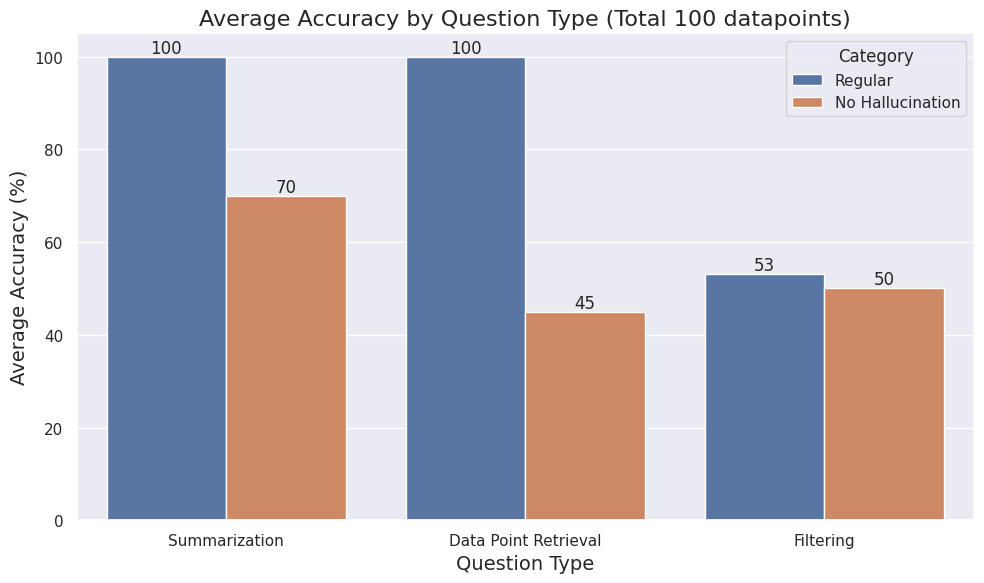

In [26]:
# Create the plot
plt.figure(
    figsize=(10, 6),
    tight_layout=True)

ax = plt.axes()
sns.barplot(data=df_combined, x='Type', y='Accuracy', hue='Category', palette='deep')
ax.bar_label(ax.containers[0], fontsize=12)
ax.bar_label(ax.containers[1], fontsize=12);

# Add title and labels
ax.set_title('Average Accuracy by Question Type (Total 100 datapoints)', fontsize=16)
ax.set_xlabel('Question Type', fontsize=14)
ax.set_ylabel('Average Accuracy (%)', fontsize=14)
# plt.xticks(rotation=45)

# Show plot with legend
ax.legend(title='Category')

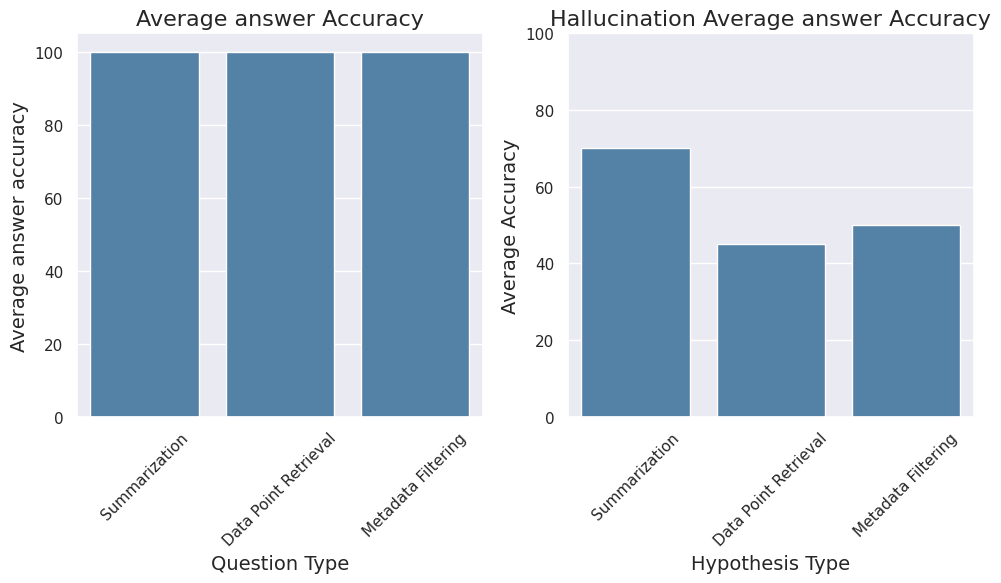

In [52]:
# Create the subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 6), tight_layout=True)

# Barplot for df1
sns.barplot(data=df1, x='Qtype', y='avg_idx_acc', ax=ax[0], color='steelblue')
ax[0].set_title('Average answer Accuracy', fontsize=16)
ax[0].set_xlabel('Question Type', fontsize=14)
ax[0].set_ylabel('Average answer accuracy', fontsize=14)
ax[0].tick_params(axis='x', rotation=45)

# Barplot for df2
sns.barplot(data=df2, x='Htype', y='avg_acc', ax=ax[1], color='steelblue')
ax[1].set_title('Hallucination Average answer Accuracy', fontsize=16)
ax[1].set_xlabel('Hypothesis Type', fontsize=14)
ax[1].set_ylabel('Average Accuracy', fontsize=14)
ax[1].set_ylim(0, 100)
ax[1].tick_params(axis='x', rotation=45)